In [1]:
import numpy as np
import pandas as pd
import os
from PIL import Image
import rasterio
import tifffile
import skimage
from matplotlib import pyplot as plt
from tqdm import tqdm
import cv2
import higra as hg
import torch
import pickle

In [2]:
# https://github.com/waldnerf/decode/blob/main/postprocessing/instance_segmentation.py
def watershed(input_hws, t_bound):
    # Create the directed graph
    size = input_hws.shape[:2]
    graph = hg.get_8_adjacency_graph(size)
    edge_weights = hg.weight_graph(
        graph,
        input_hws,
        hg.WeightFunction.mean)

    tree, altitudes = hg.watershed_hierarchy_by_dynamics(
        graph,
        edge_weights)
    
    # Get individual fields
    # by cutting the graph using altitude
    instances = hg.labelisation_horizontal_cut_from_threshold(
        tree,
        altitudes,
        threshold=t_bound).astype(float)
    return instances

In [3]:
import itertools
def compute_pair_to_iou_dict(masks):
    indices = np.arange(len(masks))
    pairs = itertools.combinations(indices, 2)
    pair_to_iou = {}
    for pair in pairs:
        i, j = pair
        pair_to_iou[tuple(pair)] = iou(masks[i], masks[j]).numpy()
    return pair_to_iou

def remove_duplicate_masks(indices, pair_to_iou, iou_threshold=0.95):
    for k in np.arange(1, len(indices)+1):
        for new_indices in itertools.combinations(indices, k):
            removed_indices = list(set(indices) - set(new_indices))
            valid_combination = True
            for i in removed_indices:
                new_indices_contain_similar_mask = False
                for j in new_indices:
                    if pair_to_iou[tuple(sorted((i, j)))] > iou_threshold:
                        new_indices_contain_similar_mask = True
                        break
                if not new_indices_contain_similar_mask:
                    valid_combination = False
                    break
            if valid_combination:
                return list(new_indices)

In [4]:
# https://stackoverflow.com/questions/66595055/fastest-way-of-computing-binary-mask-iou-with-numpy
def iou(mask1, mask2):
    intersection = (mask1 * mask2).sum()
    if intersection == 0:
        return 0.0
    union = torch.logical_or(mask1, mask2).to(torch.int).sum()
    return intersection / union

In [5]:
np.random.seed(0)

chips_df = pd.read_parquet('data/ftw/france/chips_france.parquet', engine='pyarrow')
image_numbers_test = chips_df[chips_df['split']=='test']['aoi_id'].astype('string')
image_numbers = np.random.permutation(image_numbers_test)
image_numbers_calibration = image_numbers[:250]
image_numbers_test = image_numbers[250:350]

In [6]:
T_values = np.concatenate([np.arange(0.001, 0.01, 0.001), np.arange(0, 1.01, .01)])
print(T_values)

[0.001 0.002 0.003 0.004 0.005 0.006 0.007 0.008 0.009 0.    0.01  0.02
 0.03  0.04  0.05  0.06  0.07  0.08  0.09  0.1   0.11  0.12  0.13  0.14
 0.15  0.16  0.17  0.18  0.19  0.2   0.21  0.22  0.23  0.24  0.25  0.26
 0.27  0.28  0.29  0.3   0.31  0.32  0.33  0.34  0.35  0.36  0.37  0.38
 0.39  0.4   0.41  0.42  0.43  0.44  0.45  0.46  0.47  0.48  0.49  0.5
 0.51  0.52  0.53  0.54  0.55  0.56  0.57  0.58  0.59  0.6   0.61  0.62
 0.63  0.64  0.65  0.66  0.67  0.68  0.69  0.7   0.71  0.72  0.73  0.74
 0.75  0.76  0.77  0.78  0.79  0.8   0.81  0.82  0.83  0.84  0.85  0.86
 0.87  0.88  0.89  0.9   0.91  0.92  0.93  0.94  0.95  0.96  0.97  0.98
 0.99  1.   ]


# Calibrate conformal algorithm

In [6]:
np.random.seed(0)

image_size = 256
points_per_image = 50
results = {"image_number": [], "coord": [], "IOUs": []}
for image_number in tqdm(image_numbers_calibration):
    xs = np.random.randint(image_size, size=points_per_image)
    ys = np.random.randint(image_size, size=points_per_image)
    true_segmentation = rasterio.open(os.path.join('data/ftw/france/label_masks/instance', image_number+'.tif')).read()[0]
    pred_probability = rasterio.open(os.path.join('data/ftw_predictions/france_test/predictions_3class/probability', image_number+'.tif')).read()[2]
    
    coords = []
    for x, y in zip(xs, ys):
        if true_segmentation[x, y] != 0:
            coord = (x, y)
            true_field = true_segmentation==true_segmentation[coord]
            true_field_indices = np.argwhere(true_field)
            # check if true field touches edge of image
            if (0 not in true_field_indices.flatten()) and (image_size-1 not in true_field_indices.flatten()):
                coords.append(coord)
    
    IOUs = []
    if len(coords) != 0:
        for T in T_values:
            pred_segmentation = watershed(pred_probability, T)
            IOUs_T = []
            for coord in coords:
                true_field = true_segmentation==true_segmentation[coord]
                pred_field = pred_segmentation==pred_segmentation[coord]
                IOU = iou(torch.from_numpy(true_field), torch.from_numpy(pred_field)).numpy().item()
                IOUs_T.append(IOU)
            IOUs.append(IOUs_T)
        
    
    # store results
    results["image_number"].extend(np.repeat(image_number, len(coords)))
    results["coord"].extend(coords)
    results["IOUs"].extend(np.array(IOUs).T.tolist())

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [22:51<00:00,  5.49s/it]


In [7]:
results_table = pd.DataFrame.from_dict(results)
results_table

image_number       coord  \
0      g212_00063_1  (211, 151)   
1      g212_00063_1   (165, 79)   
2      g212_00063_1   (142, 53)   
3      g165_00035_5   (177, 25)   
4      g165_00035_5   (174, 14)   
...             ...         ...   
2471  g212_00096_16  (174, 113)   
2472  g212_00096_16    (94, 60)   
2473  g212_00096_16  (186, 166)   
2474  g212_00096_16    (40, 82)   
2475  g212_00096_16    (98, 69)   

                                                   IOUs  
0     [0.18637274205684662, 0.18637274205684662, 0.1...  
1     [0.8399508595466614, 0.8399508595466614, 0.839...  
2     [0.8399508595466614, 0.8399508595466614, 0.839...  
3     [0.23930130898952484, 0.33322814106941223, 0.3...  
4     [0.09575142711400986, 0.09575142711400986, 0.0...  
...                                                 ...  
2471  [0.9535355567932129, 0.9535355567932129, 0.953...  
2472  [0.5677839517593384, 0.5675342679023743, 0.567...  
2473  [0.9535355567932129, 0.9535355567932129, 0.953...  
2474  [0.5677839517593384, 0.5675342679023743, 0.567...  
2475  [0.5677839517593384, 0.5675342679023743, 0.567...  

[2476 rows x 3 columns]

In [8]:
file = open('data/ftw_predictions/france_test/conformal_ious_more_T_values.pkl', 'wb')
pickle.dump(results_table, file)
file.close()

# Compute conformal confidence interval for watershed threshold T

In [19]:
file = open('data/ftw_predictions/france_test/conformal_ious_more_T_values.pkl', 'rb')
results_table = pickle.load(file)
file.close()

In [20]:
IOU_threshold = 0.7

def compute_Ts_with_high_IOU(IOUs):
    indices_with_high_IOU = np.argwhere(np.array(IOUs) >= IOU_threshold)[:, 0]
    return T_values[indices_with_high_IOU]

def find_T_min(Ts_with_high_IOU):
    if len(Ts_with_high_IOU) == 0:
        return np.nan
    else:
        T_min = Ts_with_high_IOU[0]
        return T_min
    
def find_T_max(Ts_with_high_IOU):
    if len(Ts_with_high_IOU) == 0:
        return np.nan
    else:
        T_max = Ts_with_high_IOU[-1]
        return T_max
    
def find_T_median(Ts_with_high_IOU):
    if len(Ts_with_high_IOU) == 0:
        return np.nan
    else:
        T_median = np.percentile(Ts_with_high_IOU, 50, interpolation='lower')
        return T_median

results_table["max IOU"] = results_table["IOUs"].map(lambda x: np.max(x))
results_table["Ts with high IOU"] = results_table["IOUs"].map(compute_Ts_with_high_IOU)
results_table["T min"] = results_table["Ts with high IOU"].map(find_T_min)
results_table["T max"] = results_table["Ts with high IOU"].map(find_T_max)
results_table["T median"] = results_table["Ts with high IOU"].map(find_T_median)
results_table

image_number       coord  \
0      g212_00063_1  (211, 151)   
1      g212_00063_1   (165, 79)   
2      g212_00063_1   (142, 53)   
3      g165_00035_5   (177, 25)   
4      g165_00035_5   (174, 14)   
...             ...         ...   
2471  g212_00096_16  (174, 113)   
2472  g212_00096_16    (94, 60)   
2473  g212_00096_16  (186, 166)   
2474  g212_00096_16    (40, 82)   
2475  g212_00096_16    (98, 69)   

                                                   IOUs   max IOU  \
0     [0.18637274205684662, 0.18637274205684662, 0.1...  0.256972   
1     [0.8399508595466614, 0.8399508595466614, 0.839...  0.885039   
2     [0.8399508595466614, 0.8399508595466614, 0.839...  0.885039   
3     [0.23930130898952484, 0.33322814106941223, 0.3...  0.409821   
4     [0.09575142711400986, 0.09575142711400986, 0.0...  0.409821   
...                                                 ...       ...   
2471  [0.9535355567932129, 0.9535355567932129, 0.953...  0.953536   
2472  [0.5677839517593384, 0.5675342679023743, 0.567...  0.567784   
2473  [0.9535355567932129, 0.9535355567932129, 0.953...  0.953536   
2474  [0.5677839517593384, 0.5675342679023743, 0.567...  0.567784   
2475  [0.5677839517593384, 0.5675342679023743, 0.567...  0.567784   

                                       Ts with high IOU  T min  T max  \
0                                                    []    NaN    NaN   
1     [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.0...  0.001   0.62   
2     [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.0...  0.001   0.62   
3                                                    []    NaN    NaN   
4                                                    []    NaN    NaN   
...                                                 ...    ...    ...   
2471  [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.0...  0.001   0.01   
2472                                                 []    NaN    NaN   
2473  [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.0...  0.001   0.01   
2474                                                 []    NaN    NaN   
2475                                                 []    NaN    NaN   

      T median  
0          NaN  
1        0.270  
2        0.270  
3          NaN  
4          NaN  
...        ...  
2471     0.005  
2472       NaN  
2473     0.005  
2474       NaN  
2475       NaN  

[2476 rows x 8 columns]

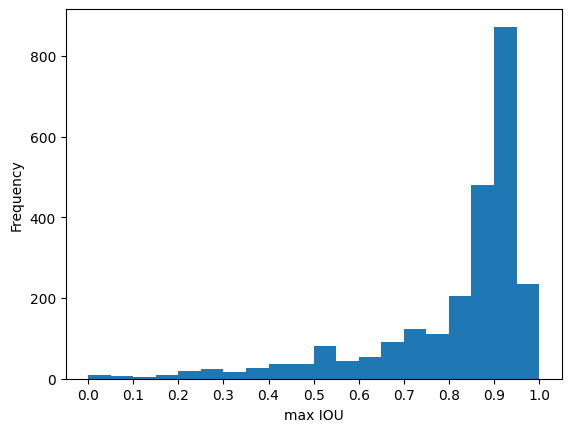

In [21]:
plt.hist(results_table["max IOU"], bins=np.arange(0, 1.01, .05))
plt.xlabel("max IOU")
plt.ylabel("Frequency")
plt.xticks(np.arange(0, 1.01, 0.1))
plt.show()

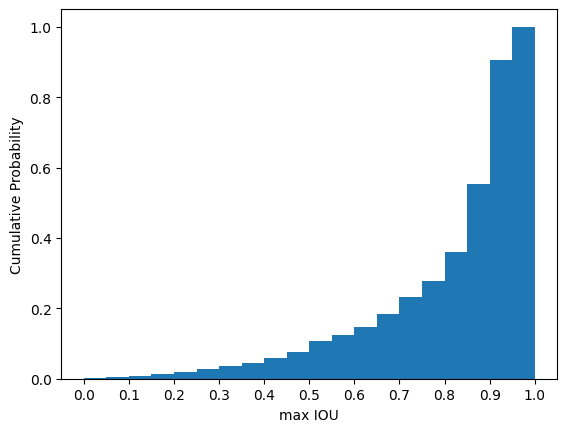

In [22]:
plt.hist(results_table["max IOU"], bins=np.arange(0, 1.01, .05), density=True, cumulative=True)
plt.xlabel("max IOU")
plt.ylabel("Cumulative Probability")
plt.xticks(np.arange(0, 1.01, 0.1))
plt.show()

# Find conformal set T values

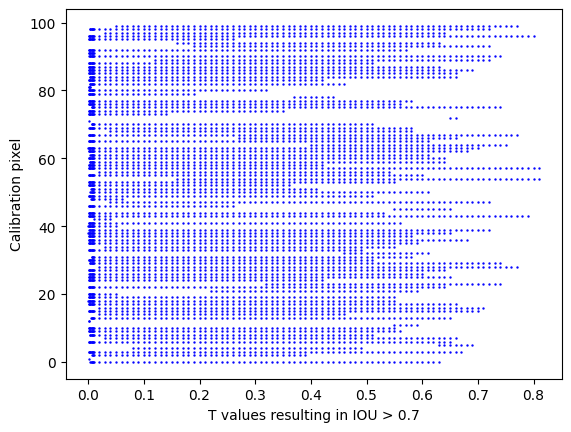

In [23]:
np.random.seed(0)

results_table_high_IOUs = results_table[results_table["max IOU"] > IOU_threshold]
results_table_high_IOUs = results_table_high_IOUs.sample(n=100)
Ts_with_high_IOU = np.array(results_table_high_IOUs["Ts with high IOU"])

for i in range(len(Ts_with_high_IOU)):
    xs = Ts_with_high_IOU[i]
    ys = np.repeat(i, len(xs))
    plt.scatter(xs, ys, color='blue', s=0.5)
    plt.xlabel(f"T values resulting in IOU > {IOU_threshold}")
    plt.ylabel("Calibration pixel")
    #plt.xticks(np.arange(0, 1.01, 0.1))

In [29]:
import itertools
import math

alpha = .2
results_table_high_IOUs = results_table[results_table["max IOU"] > IOU_threshold]
p = 1 - len(results_table_high_IOUs) / len(results_table)
print(p)
if p > alpha:
    print("too uncertain")
else:
    IOUs = np.array([np.array(x) for x in results_table["IOUs"]])
    IOUs_high = (IOUs>IOU_threshold).astype(int)
    T_confidence_set = []
    num_calibration_pixels_covered = 0
    num_calibration_pixels_target = (1-alpha)*len(results_table)
    while num_calibration_pixels_covered < num_calibration_pixels_target:
        coverage_by_T = IOUs_high.sum(axis=0)
        best_T = np.argmax(coverage_by_T)
        calibration_pixels_covered = np.argwhere(IOUs_high[:, best_T]==1)
        IOUs_high = np.delete(IOUs_high, calibration_pixels_covered, axis=0)
        
        T_confidence_set.append(best_T)
        num_calibration_pixels_covered += np.max(coverage_by_T)

        print(T_values[best_T])
        print("Percent of calibration pixels covered so far:", num_calibration_pixels_covered/len(results_table))
    
    T_confidence_set = T_values[np.sort(T_confidence_set)]
    print("Greedy algorithm output:", T_confidence_set)

    IOUs_high = (IOUs>IOU_threshold).astype(int)
    n = IOUs_high.shape[1]
    indices = np.arange(n)
    m = len(T_confidence_set)
    for k in np.arange(2, m):
        print("Trying subsets of size", k)
        for indices_subset in tqdm(itertools.combinations(indices, k), total=math.comb(n,k)):
            IOUs_high_subset = IOUs_high[:, indices_subset]
            num_calibration_pixels_covered = (IOUs_high_subset.sum(axis=1) > 0).sum(axis=0)
            if num_calibration_pixels_covered >= num_calibration_pixels_target:
                T_confidence_set = np.sort(T_values[np.array(indices_subset)])
                break
        if num_calibration_pixels_covered >= num_calibration_pixels_target:
            break
                
    print("Final output:", T_confidence_set)
            

0.1825525040387722
0.24
Percent of calibration pixels covered so far: 0.6688206785137318
0.001
Percent of calibration pixels covered so far: 0.7362681744749596
0.58
Percent of calibration pixels covered so far: 0.7758481421647819
0.06
Percent of calibration pixels covered so far: 0.789983844911147
0.35000000000000003
Percent of calibration pixels covered so far: 0.7992730210016155
0.6900000000000001
Percent of calibration pixels covered so far: 0.8041195476575121
Greedy algorithm output: [0.001 0.06  0.24  0.35  0.58  0.69 ]
Trying subsets of size 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5995/5995 [00:00<00:00, 36727.97it/s]


Trying subsets of size 3


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 215820/215820 [00:05<00:00, 36627.83it/s]


Trying subsets of size 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5773185/5773185 [03:07<00:00, 30716.40it/s]


Trying subsets of size 5


  0%|▎                                                                                                                                                 | 290516/122391522 [00:10<1:13:13, 27789.10it/s]

Final output: [0.001 0.003 0.12  0.31  0.58 ]


# Investigate NaNs

g165_00003_9
MAX IOU: 0.42300355434417725


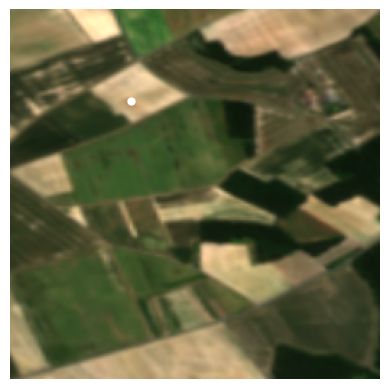

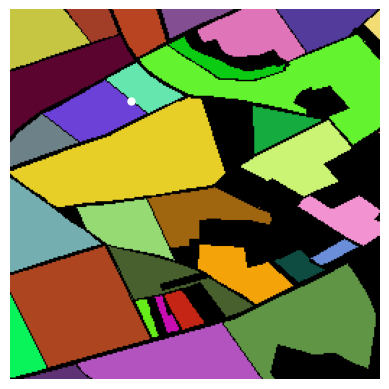

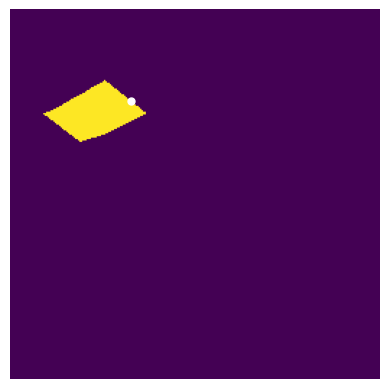

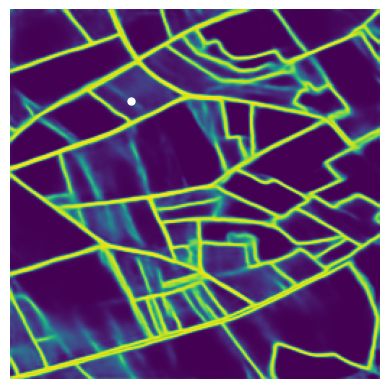

g212_00066_14
MAX IOU: 0.36056002974510193


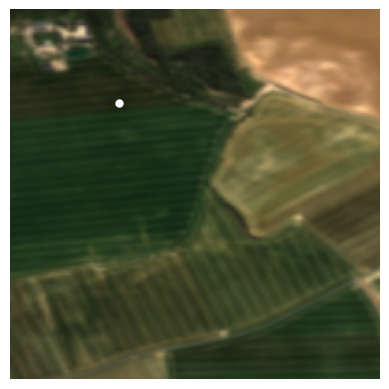

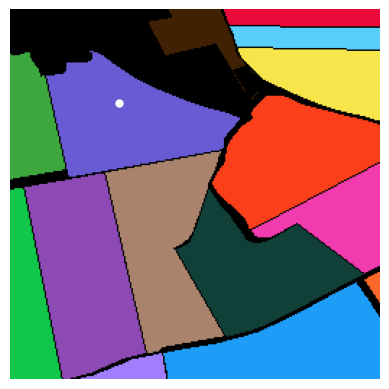

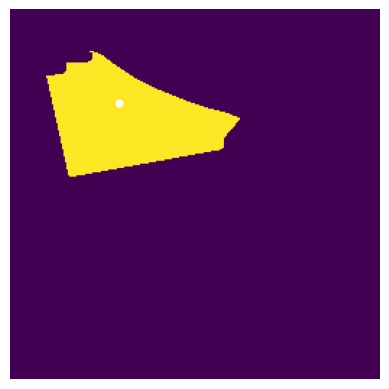

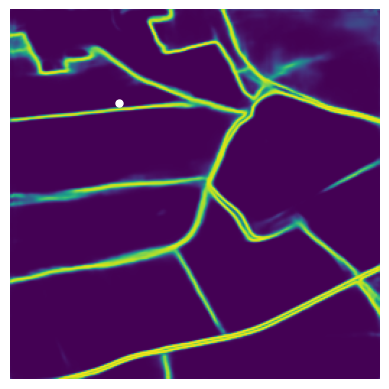

g212_00010_15
MAX IOU: 0.6960647702217102


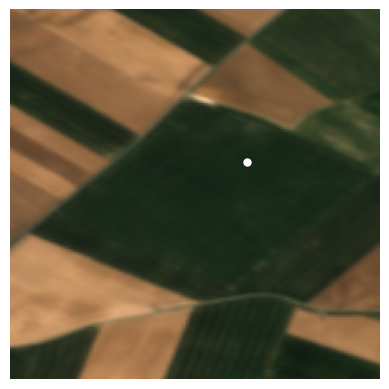

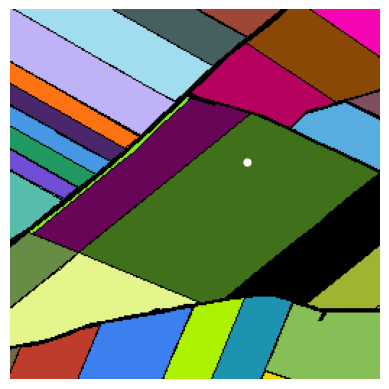

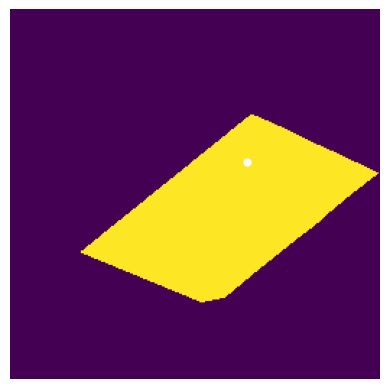

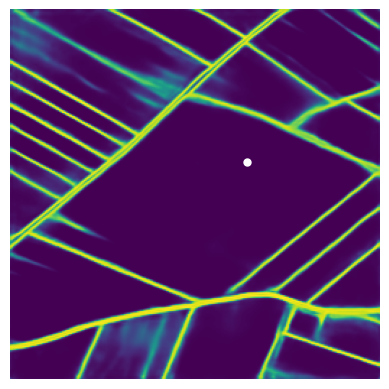

g165_00042_12
MAX IOU: 0.5426744222640991


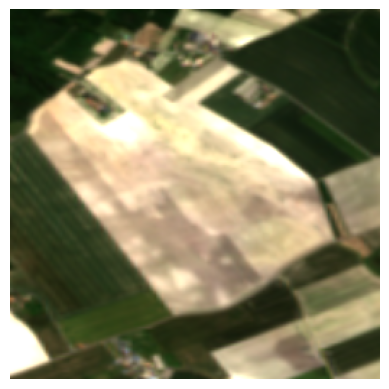

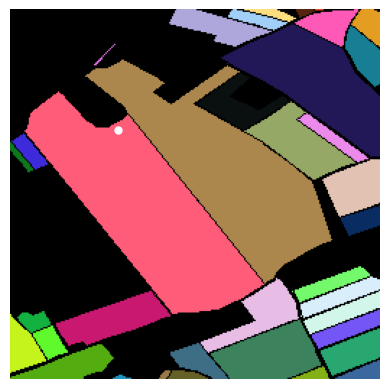

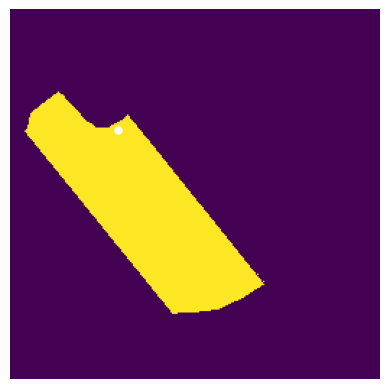

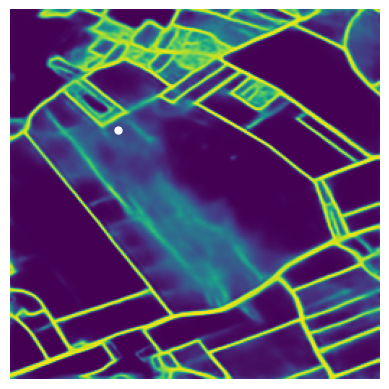

g212_00070_1
MAX IOU: 0.6386169195175171


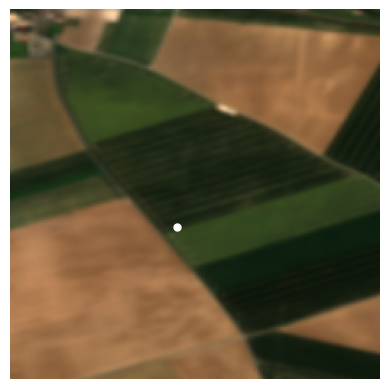

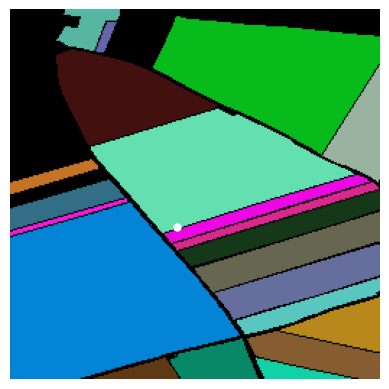

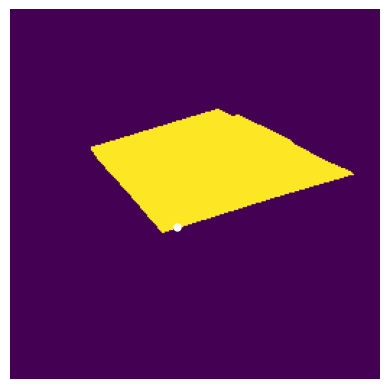

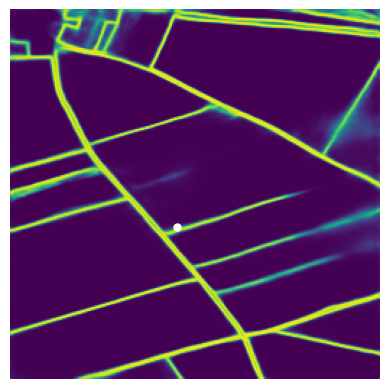

In [24]:
from skimage.color import label2rgb

np.random.seed(0)
results_table_nans = results_table[np.isnan(results_table['T min'])]
results_table_nans = results_table_nans.sample(n=5)

for index, row in results_table_nans.iterrows():
    image_number = row["image_number"]
    coord = row["coord"]

    print(image_number)
    print("MAX IOU:", row["max IOU"])
    rgb_img = rasterio.open(os.path.join('data/ftw_predictions/france_test/inputs_stacked', image_number+'.tif')).read()
    rgb_img = rgb_img[0:3].transpose(1, 2, 0)/ 3000
    plt.imshow(np.clip(rgb_img, 0, 1))
    plt.plot(coord[1], coord[0], "o", color="white", markersize=5)
    plt.axis('off')
    plt.show()

    #print("True Segmentation")
    true_segmentation = rasterio.open(os.path.join('data/ftw/france/label_masks/instance', image_number+'.tif')).read()[0]
    unique_labels = np.unique(true_segmentation)
    colors = [(np.random.rand(), np.random.rand(), np.random.rand()) for _ in unique_labels]
    true_segmentation_vis = label2rgb(true_segmentation, bg_label=0, bg_color=(0, 0, 0), colors=colors)
    plt.imshow(true_segmentation_vis)
    plt.plot(coord[1], coord[0], "o", color="white", markersize=5)
    plt.axis('off')
    plt.show()

    plt.imshow(true_segmentation==true_segmentation[coord[0].item(), coord[1].item()])
    plt.plot(coord[1], coord[0], "o", color="white", markersize=5)
    plt.axis('off')
    plt.show()
    
    #print("Predicted Boundary Probabilities")
    pred_probability = rasterio.open(os.path.join('data/ftw_predictions/france_test/predictions_3class/probability', image_number+'.tif')).read()[2]
    plt.imshow(pred_probability)
    plt.plot(coord[1], coord[0], "o", color="white", markersize=5)
    plt.axis('off')
    plt.show()

    #pred_segmentation = watershed(pred_probability, 0.26)
    #plt.imshow(pred_segmentation==pred_segmentation[coord[0].item(), coord[1].item()])
    #plt.plot(coord[1], coord[0], "o", color="white", markersize=5)
    #plt.axis('off')
    #plt.show()

# Get field delineation confidence intervals for test images

g165_00003_0


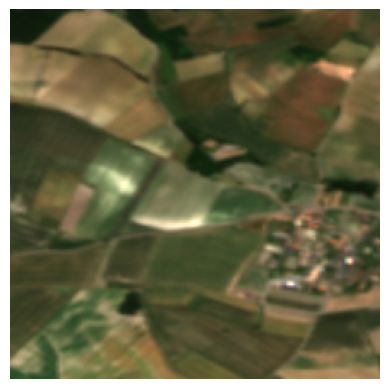

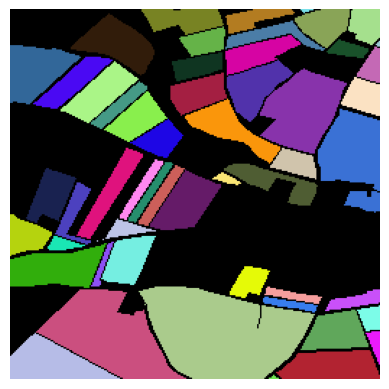

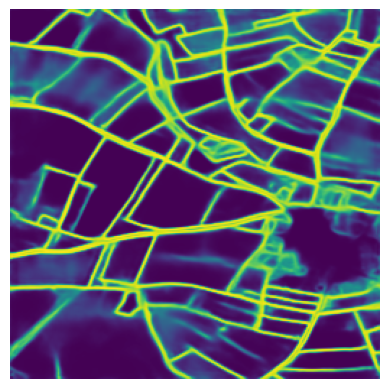

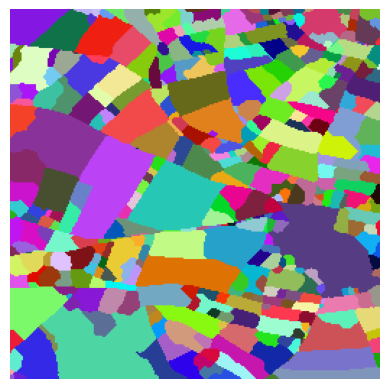

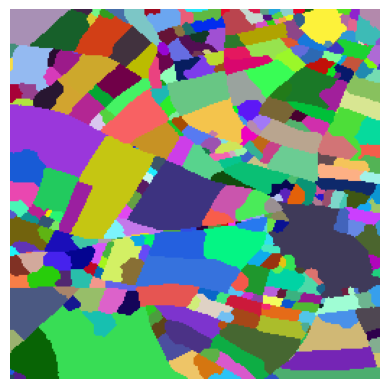

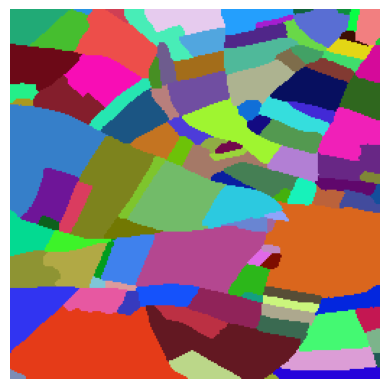

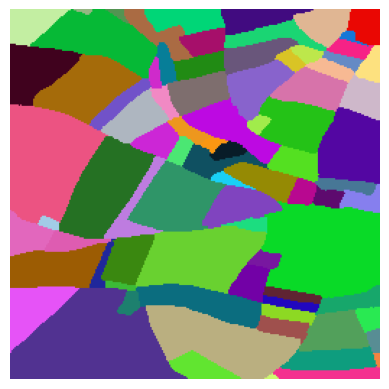

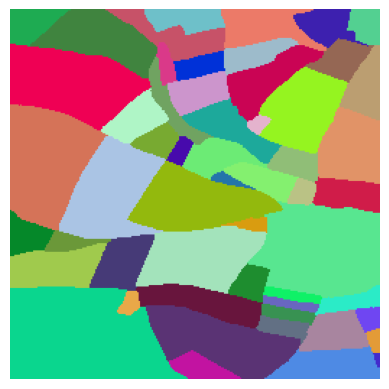

g165_00054_4


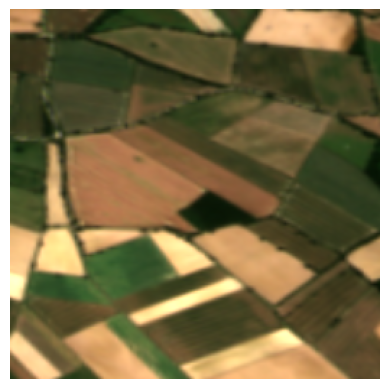

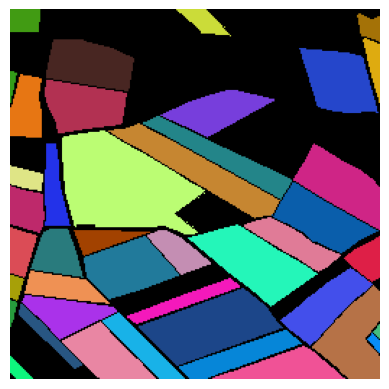

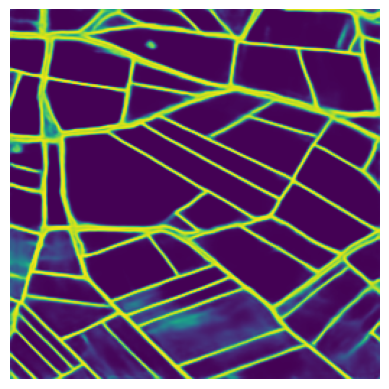

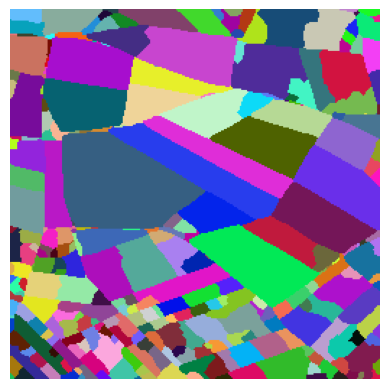

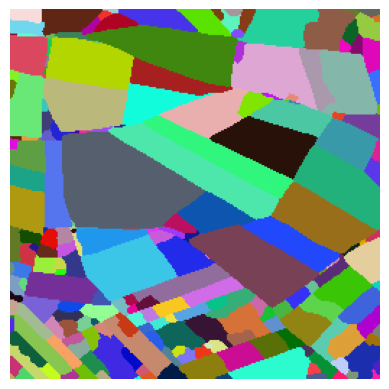

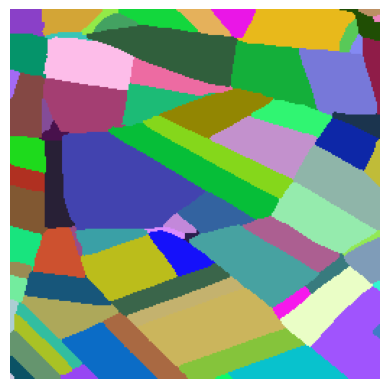

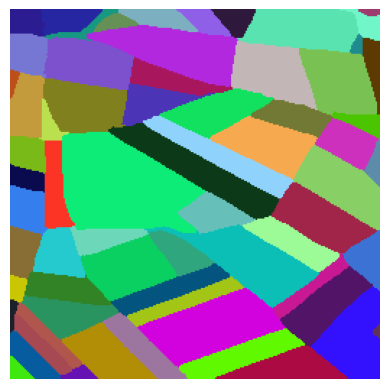

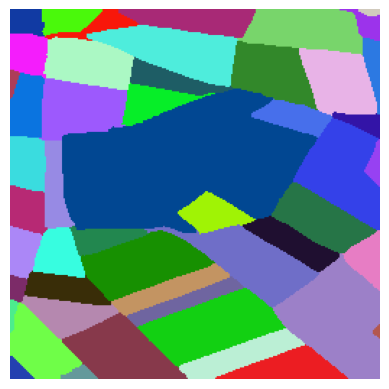

g165_00005_6


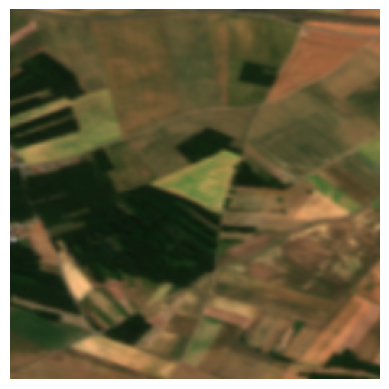

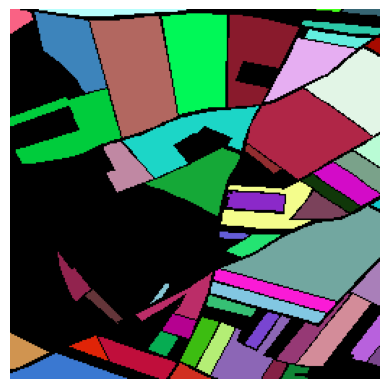

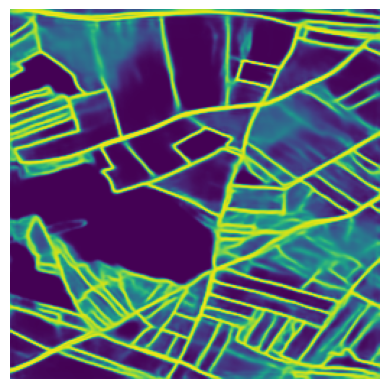

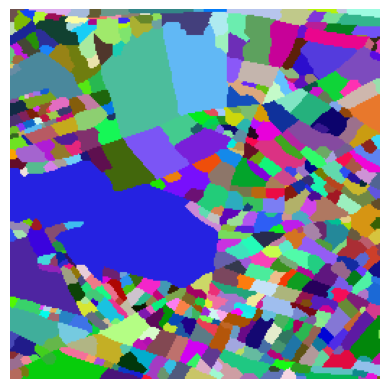

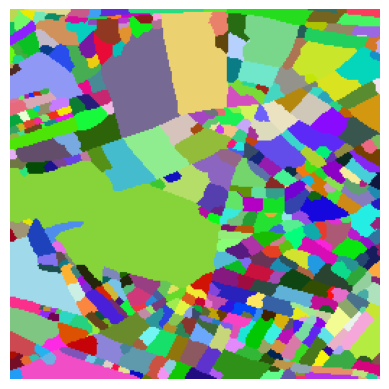

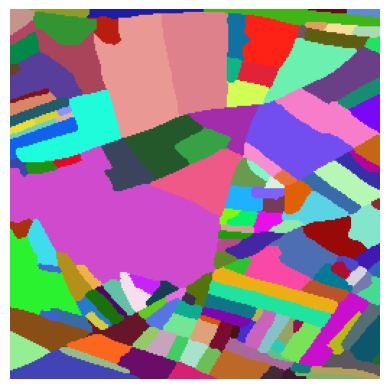

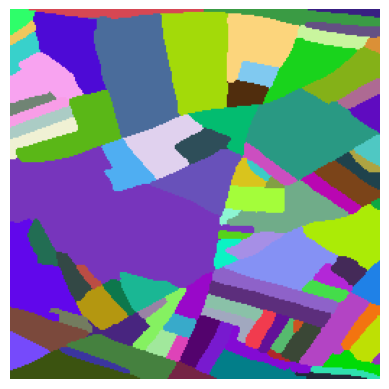

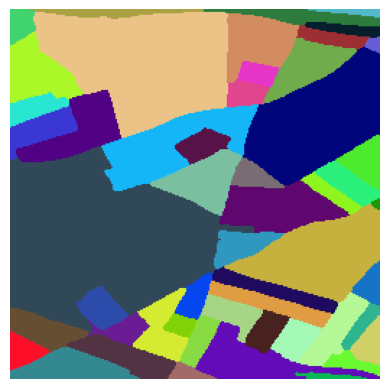

g165_00036_7


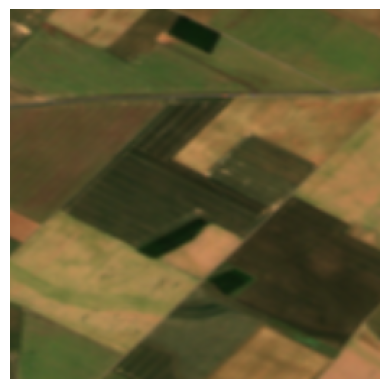

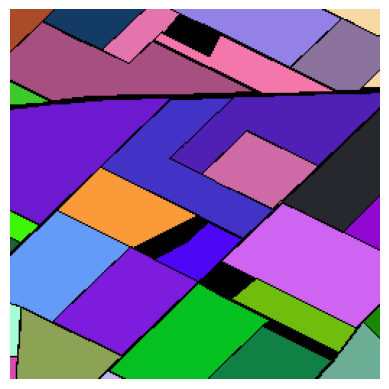

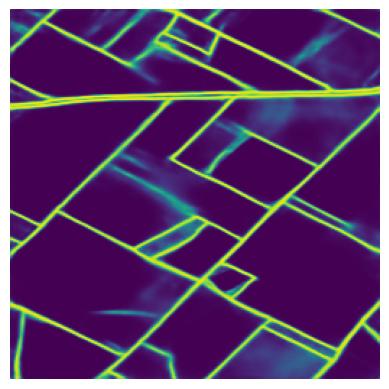

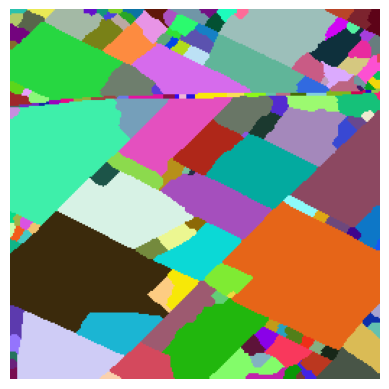

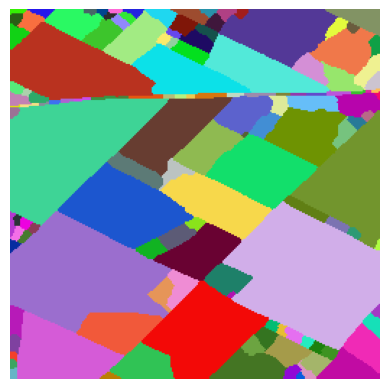

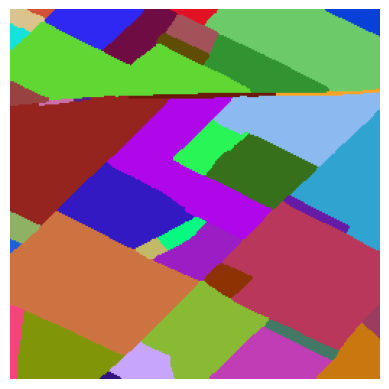

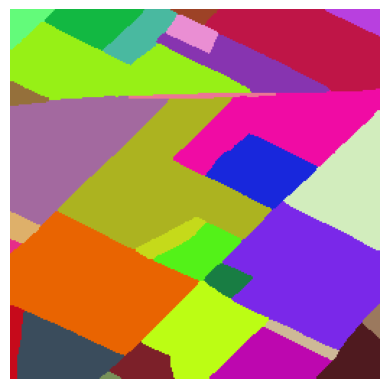

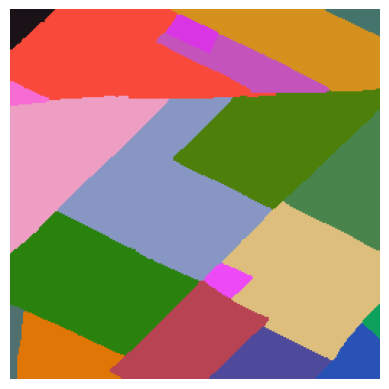

g212_00034_15


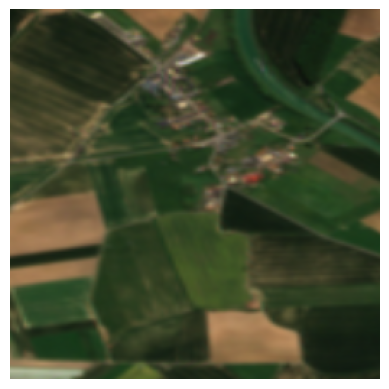

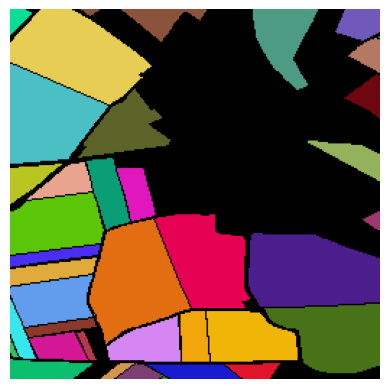

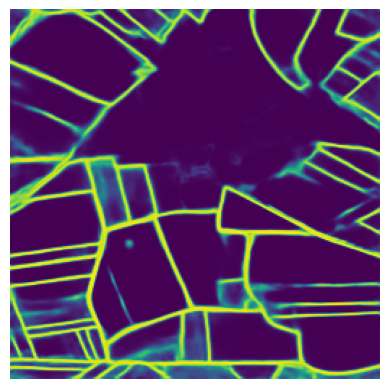

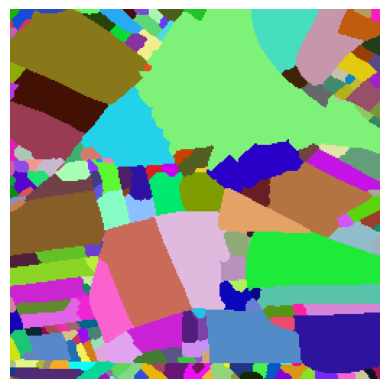

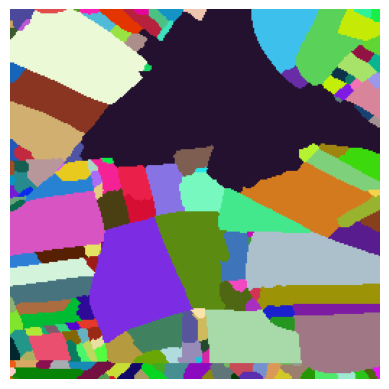

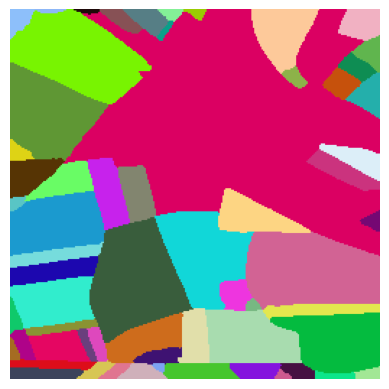

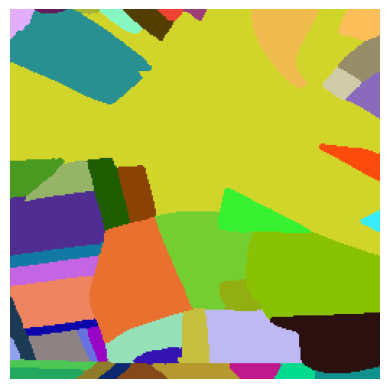

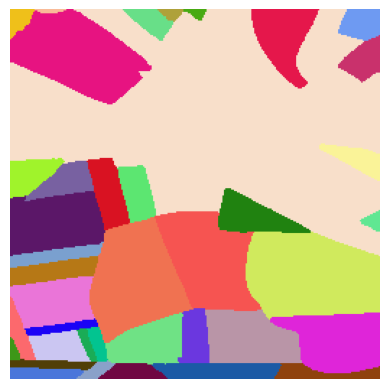

In [30]:
from skimage.color import label2rgb

for image_number in image_numbers_test[:5]:
    true_segmentation = rasterio.open(os.path.join('data/ftw/france/label_masks/instance', image_number+'.tif')).read()[0]
    unique_labels = np.unique(true_segmentation)
    colors = [(np.random.rand(), np.random.rand(), np.random.rand()) for _ in unique_labels]
    true_segmentation = label2rgb(true_segmentation, bg_label=0, bg_color=(0, 0, 0), colors=colors)
    
    pred_probability = rasterio.open(os.path.join('data/ftw_predictions/france_test/predictions_3class/probability', image_number+'.tif')).read()[2]
    
    print(image_number)
    rgb_img = rasterio.open(os.path.join('data/ftw_predictions/france_test/inputs_stacked', image_number+'.tif')).read()
    rgb_img = rgb_img[0:3].transpose(1, 2, 0)/ 3000
    plt.imshow(np.clip(rgb_img, 0, 1))
    plt.axis('off')
    plt.show()
    #print("True Segmentation")
    plt.imshow(true_segmentation)
    plt.axis('off')
    plt.show()
    #print("Predicted Boundary Probabilities")
    plt.imshow(pred_probability)
    plt.axis('off')
    plt.show()
    #print("Confidence Set")
    for T in T_confidence_set:
        pred_segmentation = watershed(pred_probability, T)
        unique_labels = np.unique(pred_segmentation)
        colors = [(np.random.rand(), np.random.rand(), np.random.rand()) for _ in unique_labels]
        pred_segmentation = label2rgb(pred_segmentation, colors=colors)
        plt.imshow(pred_segmentation)
        plt.axis('off')
        plt.show()

# Check conformal coverage on test set

In [31]:
np.random.seed(0)

image_size = 256
points_per_image = 50
results = {"image_number": [], "coord": [], "IOUs": []}
for image_number in tqdm(image_numbers_test):
    xs = np.random.randint(image_size, size=points_per_image)
    ys = np.random.randint(image_size, size=points_per_image)
    true_segmentation = rasterio.open(os.path.join('data/ftw/france/label_masks/instance', image_number+'.tif')).read()[0]
    pred_probability = rasterio.open(os.path.join('data/ftw_predictions/france_test/predictions_3class/probability', image_number+'.tif')).read()[2]
    
    coords = []
    for x, y in zip(xs, ys):
        if true_segmentation[x, y] != 0:
            coord = (x, y)
            true_field = true_segmentation==true_segmentation[coord]
            true_field_indices = np.argwhere(true_field)
            # check if true field touches edge of image
            if (0 not in true_field_indices.flatten()) and (image_size-1 not in true_field_indices.flatten()):
                coords.append(coord)
    
    IOUs = []
    if len(coords) != 0:
        for T in T_confidence_set:
            pred_segmentation = watershed(pred_probability, T)
            IOUs_T = []
            for coord in coords:
                true_field = true_segmentation==true_segmentation[coord]
                pred_field = pred_segmentation==pred_segmentation[coord]
                IOU = iou(torch.from_numpy(true_field), torch.from_numpy(pred_field)).numpy().item()
                IOUs_T.append(IOU)
            IOUs.append(IOUs_T)
        
    
    # store results
    results["image_number"].extend(np.repeat(image_number, len(coords)))
    results["coord"].extend(coords)
    results["IOUs"].extend(np.array(IOUs).T.tolist())

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:27<00:00,  3.63it/s]


In [32]:
results_table_test = pd.DataFrame.from_dict(results)
results_table_test

image_number       coord  \
0    g165_00003_0   (67, 127)   
1    g165_00003_0  (103, 202)   
2    g165_00003_0   (21, 163)   
3    g165_00003_0   (87, 114)   
4    g165_00003_0   (70, 183)   
..            ...         ...   
912  g212_00037_6  (161, 131)   
913  g212_00037_6   (117, 86)   
914  g212_00037_6  (106, 129)   
915  g212_00037_6  (200, 155)   
916  g212_00037_6  (105, 128)   

                                                  IOUs  
0    [0.8354430198669434, 0.8354430198669434, 0.835...  
1    [0.7164685726165771, 0.7164685726165771, 0.716...  
2    [0.0793650820851326, 0.4658273458480835, 0.575...  
3    [0.8576778769493103, 0.8576778769493103, 0.851...  
4    [0.1233123317360878, 0.1233123317360878, 0.252...  
..                                                 ...  
912  [0.5572687387466431, 0.5572687387466431, 0.858...  
913  [0.9332780838012695, 0.9332780838012695, 0.933...  
914  [0.9503437876701355, 0.9503437876701355, 0.537...  
915  [0.1414935439825058, 0.1414935439825058, 0.946...  
916  [0.9503437876701355, 0.9503437876701355, 0.537...  

[917 rows x 3 columns]

In [33]:
# Compute coverage
results_table_test["max IOU"] = results_table_test["IOUs"].map(lambda x: np.max(x))
results_table_test_high_IOUs = results_table_test[results_table_test["max IOU"] > IOU_threshold]
coverage = len(results_table_test_high_IOUs) / len(results_table_test)
print(coverage)

0.7960741548527808


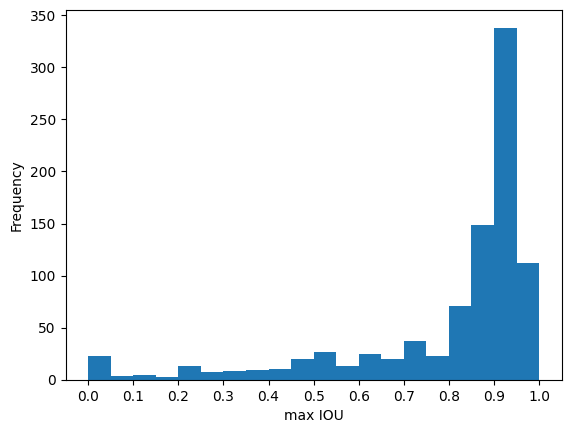

In [34]:
plt.hist(results_table_test["max IOU"], bins=np.arange(0, 1.01, .05))
plt.xlabel("max IOU")
plt.ylabel("Frequency")
plt.xticks(np.arange(0, 1.01, 0.1))
plt.show()

In [35]:
results_table_test

image_number       coord  \
0    g165_00003_0   (67, 127)   
1    g165_00003_0  (103, 202)   
2    g165_00003_0   (21, 163)   
3    g165_00003_0   (87, 114)   
4    g165_00003_0   (70, 183)   
..            ...         ...   
912  g212_00037_6  (161, 131)   
913  g212_00037_6   (117, 86)   
914  g212_00037_6  (106, 129)   
915  g212_00037_6  (200, 155)   
916  g212_00037_6  (105, 128)   

                                                  IOUs   max IOU  
0    [0.8354430198669434, 0.8354430198669434, 0.835...  0.835443  
1    [0.7164685726165771, 0.7164685726165771, 0.716...  0.716469  
2    [0.0793650820851326, 0.4658273458480835, 0.575...  0.752280  
3    [0.8576778769493103, 0.8576778769493103, 0.851...  0.857678  
4    [0.1233123317360878, 0.1233123317360878, 0.252...  0.939123  
..                                                 ...       ...  
912  [0.5572687387466431, 0.5572687387466431, 0.858...  0.858342  
913  [0.9332780838012695, 0.9332780838012695, 0.933...  0.933278  
914  [0.9503437876701355, 0.9503437876701355, 0.537...  0.950344  
915  [0.1414935439825058, 0.1414935439825058, 0.946...  0.946208  
916  [0.9503437876701355, 0.9503437876701355, 0.537...  0.950344  

[917 rows x 4 columns]

In [36]:
file = open('data/ftw_predictions/france_test/conformal_ious_test_more_T_values_improved.pkl', 'wb')
pickle.dump(results_table_test, file)
file.close()

# Remove duplicate predicted masks

In [38]:
np.random.seed(0)

image_size = 256
points_per_image = 50
results = {"image_number": [], "coord": [], "IOUs": [], "Pred Mask Pair to IOUs": []}
for image_number in tqdm(image_numbers_test):
    xs = np.random.randint(image_size, size=points_per_image)
    ys = np.random.randint(image_size, size=points_per_image)
    true_segmentation = rasterio.open(os.path.join('data/ftw/france/label_masks/instance', image_number+'.tif')).read()[0]
    pred_probability = rasterio.open(os.path.join('data/ftw_predictions/france_test/predictions_3class/probability', image_number+'.tif')).read()[2]
    
    coords = []
    for x, y in zip(xs, ys):
        if true_segmentation[x, y] != 0:
            coord = (x, y)
            true_field = true_segmentation==true_segmentation[coord]
            true_field_indices = np.argwhere(true_field)
            # check if true field touches edge of image
            if (0 not in true_field_indices.flatten()) and (image_size-1 not in true_field_indices.flatten()):
                coords.append(coord)
    
    IOUs = []
    pred_shapes = []
    if len(coords) != 0:
        for T in T_confidence_set:
            pred_segmentation = watershed(pred_probability, T)
            IOUs_T = []
            pred_shapes_T = []
            for coord in coords:
                true_field = true_segmentation==true_segmentation[coord]
                pred_field = pred_segmentation==pred_segmentation[coord]
                IOU = iou(torch.from_numpy(true_field), torch.from_numpy(pred_field))
                pred_shapes_T.append(pred_field)
                IOUs_T.append(IOU)
            IOUs.append(IOUs_T)
            pred_shapes.append(pred_shapes_T)
        pair_to_iou_dicts = []
        for pred_shapes_coord in torch.from_numpy(np.swapaxes(pred_shapes, 0, 1)):
            pair_to_iou_dicts.append(compute_pair_to_iou_dict(pred_shapes_coord))
    
        # store results
        results["image_number"].extend(np.repeat(image_number, len(coords)))
        results["coord"].extend(coords)
        results["IOUs"].extend(np.array(IOUs).T.tolist())
        results["Pred Mask Pair to IOUs"].extend(pair_to_iou_dicts)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:27<00:00,  3.65it/s]


In [39]:
results_table_test = pd.DataFrame.from_dict(results)
results_table_test

image_number       coord  \
0    g165_00003_0   (67, 127)   
1    g165_00003_0  (103, 202)   
2    g165_00003_0   (21, 163)   
3    g165_00003_0   (87, 114)   
4    g165_00003_0   (70, 183)   
..            ...         ...   
912  g212_00037_6  (161, 131)   
913  g212_00037_6   (117, 86)   
914  g212_00037_6  (106, 129)   
915  g212_00037_6  (200, 155)   
916  g212_00037_6  (105, 128)   

                                                  IOUs  \
0    [0.8354430198669434, 0.8354430198669434, 0.835...   
1    [0.7164685726165771, 0.7164685726165771, 0.716...   
2    [0.0793650820851326, 0.4658273458480835, 0.575...   
3    [0.8576778769493103, 0.8576778769493103, 0.851...   
4    [0.1233123317360878, 0.1233123317360878, 0.252...   
..                                                 ...   
912  [0.5572687387466431, 0.5572687387466431, 0.858...   
913  [0.9332780838012695, 0.9332780838012695, 0.933...   
914  [0.9503437876701355, 0.9503437876701355, 0.537...   
915  [0.1414935439825058, 0.1414935439825058, 0.946...   
916  [0.9503437876701355, 0.9503437876701355, 0.537...   

                                Pred Mask Pair to IOUs  
0    {(0, 1): 1.0, (0, 2): 1.0, (0, 3): 1.0, (0, 4)...  
1    {(0, 1): 1.0, (0, 2): 1.0, (0, 3): 1.0, (0, 4)...  
2    {(0, 1): 0.15047021, (0, 2): 0.11401425, (0, 3...  
3    {(0, 1): 1.0, (0, 2): 0.9918367, (0, 3): 0.991...  
4    {(0, 1): 1.0, (0, 2): 0.4939551, (0, 3): 0.208...  
..                                                 ...  
912  {(0, 1): 1.0, (0, 2): 0.62302005, (0, 3): 0.62...  
913  {(0, 1): 1.0, (0, 2): 1.0, (0, 3): 1.0, (0, 4)...  
914  {(0, 1): 1.0, (0, 2): 0.53919697, (0, 3): 0.53...  
915  {(0, 1): 1.0, (0, 2): 0.14555256, (0, 3): 0.14...  
916  {(0, 1): 1.0, (0, 2): 0.53919697, (0, 3): 0.53...  

[917 rows x 4 columns]

In [40]:
# Compute coverage
results_table_test["max IOU"] = results_table_test["IOUs"].map(lambda x: np.max(x))
results_table_test_high_IOUs = results_table_test[results_table_test["max IOU"] > IOU_threshold]
coverage = len(results_table_test_high_IOUs) / len(results_table_test)
print(coverage)

0.7960741548527808


In [41]:
file = open('data/ftw_predictions/france_test/conformal_ious_test_with_pairwise_IOUs_more_T_values.pkl', 'wb')
pickle.dump(results_table_test, file)
file.close()

0.8429661941112323
0.7949836423118866


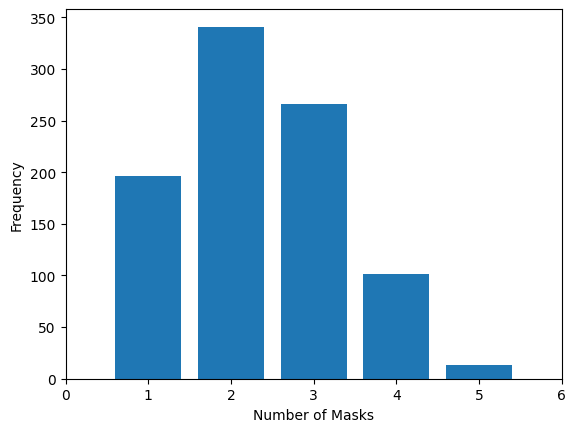

image_number       coord  \
0    g165_00003_0   (67, 127)   
1    g165_00003_0  (103, 202)   
2    g165_00003_0   (21, 163)   
3    g165_00003_0   (87, 114)   
4    g165_00003_0   (70, 183)   
..            ...         ...   
912  g212_00037_6  (161, 131)   
913  g212_00037_6   (117, 86)   
914  g212_00037_6  (106, 129)   
915  g212_00037_6  (200, 155)   
916  g212_00037_6  (105, 128)   

                                                  IOUs  \
0    [0.8354430198669434, 0.8354430198669434, 0.835...   
1    [0.7164685726165771, 0.7164685726165771, 0.716...   
2    [0.0793650820851326, 0.4658273458480835, 0.575...   
3    [0.8576778769493103, 0.8576778769493103, 0.851...   
4    [0.1233123317360878, 0.1233123317360878, 0.252...   
..                                                 ...   
912  [0.5572687387466431, 0.5572687387466431, 0.858...   
913  [0.9332780838012695, 0.9332780838012695, 0.933...   
914  [0.9503437876701355, 0.9503437876701355, 0.537...   
915  [0.1414935439825058, 0.1414935439825058, 0.946...   
916  [0.9503437876701355, 0.9503437876701355, 0.537...   

                                Pred Mask Pair to IOUs   max IOU  \
0    {(0, 1): 1.0, (0, 2): 1.0, (0, 3): 1.0, (0, 4)...  0.835443   
1    {(0, 1): 1.0, (0, 2): 1.0, (0, 3): 1.0, (0, 4)...  0.716469   
2    {(0, 1): 0.15047021, (0, 2): 0.11401425, (0, 3...  0.752280   
3    {(0, 1): 1.0, (0, 2): 0.9918367, (0, 3): 0.991...  0.857678   
4    {(0, 1): 1.0, (0, 2): 0.4939551, (0, 3): 0.208...  0.939123   
..                                                 ...       ...   
912  {(0, 1): 1.0, (0, 2): 0.62302005, (0, 3): 0.62...  0.858342   
913  {(0, 1): 1.0, (0, 2): 1.0, (0, 3): 1.0, (0, 4)...  0.933278   
914  {(0, 1): 1.0, (0, 2): 0.53919697, (0, 3): 0.53...  0.950344   
915  {(0, 1): 1.0, (0, 2): 0.14555256, (0, 3): 0.14...  0.946208   
916  {(0, 1): 1.0, (0, 2): 0.53919697, (0, 3): 0.53...  0.950344   

    Final Mask Indices  Final Mask Number  \
0                  [0]                  1   
1                  [0]                  1   
2      [0, 1, 2, 3, 4]                  5   
3                  [0]                  1   
4         [0, 2, 3, 4]                  4   
..                 ...                ...   
912          [0, 2, 4]                  3   
913                [0]                  1   
914          [0, 2, 4]                  3   
915          [0, 2, 4]                  3   
916          [0, 2, 4]                  3   

                                       Final Mask IOUs  Final Mask max IOU  
0                                 [0.8354430198669434]            0.835443  
1                                 [0.7164685726165771]            0.716469  
2    [0.0793650820851326, 0.4658273458480835, 0.575...            0.752280  
3                                 [0.8576778769493103]            0.857678  
4    [0.1233123317360878, 0.2523574233055115, 0.576...            0.939123  
..                                                 ...                 ...  
912  [0.5572687387466431, 0.8583420515060425, 0.383...            0.858342  
913                               [0.9332780838012695]            0.933278  
914  [0.9503437876701355, 0.5370800495147705, 0.345...            0.950344  
915  [0.1414935439825058, 0.9462076425552368, 0.299...            0.946208  
916  [0.9503437876701355, 0.5370800495147705, 0.345...            0.950344  

[917 rows x 9 columns]

In [42]:
indices = np.arange(len(T_confidence_set))
IOU_threshold_duplicate_mask = 0.9
results_table_test["Final Mask Indices"] = results_table_test["Pred Mask Pair to IOUs"].apply(lambda x: remove_duplicate_masks(indices, x, iou_threshold=IOU_threshold_duplicate_mask))

results_table_test["Final Mask Number"] = results_table_test["Final Mask Indices"].apply(lambda x: len(x))
results_table_test["Final Mask IOUs"] = results_table_test.apply(lambda x: np.array(x["IOUs"])[x["Final Mask Indices"]], axis=1)
results_table_test["Final Mask max IOU"] = results_table_test["Final Mask IOUs"].map(lambda x: np.max(x))

# Compute coverage after removing duplicate masks
p = IOU_threshold + IOU_threshold_duplicate_mask - 1
results_table_test_high_IOUs = results_table_test[results_table_test["Final Mask max IOU"] > p]
coverage = len(results_table_test_high_IOUs) / len(results_table_test)
print(coverage)

results_table_test_high_IOUs = results_table_test[results_table_test["Final Mask max IOU"] > IOU_threshold]
coverage = len(results_table_test_high_IOUs) / len(results_table_test)
print(coverage)

plt.bar(results_table_test['Final Mask Number'].value_counts().index, results_table_test['Final Mask Number'].value_counts().values)
plt.xticks(np.arange(0, 7))
plt.xlabel("Number of Masks")
plt.ylabel("Frequency")
plt.show()

results_table_test

g212_00054_15
MAX IOU: 0.9471971988677979
Final MAX IOU: 0.9296835660934448


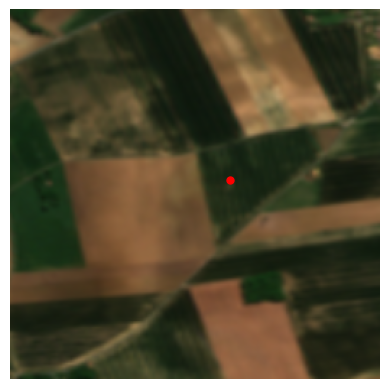

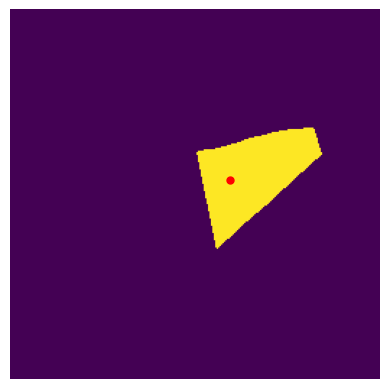

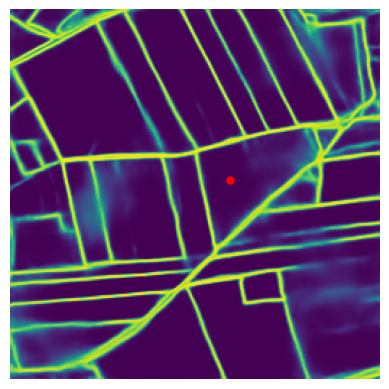

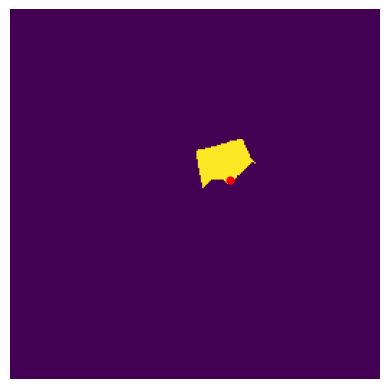

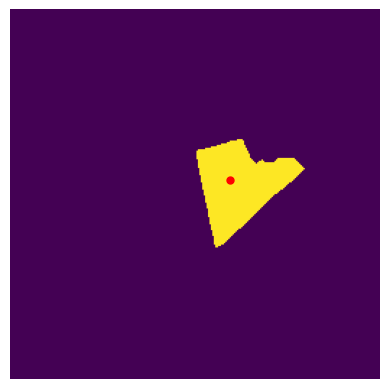

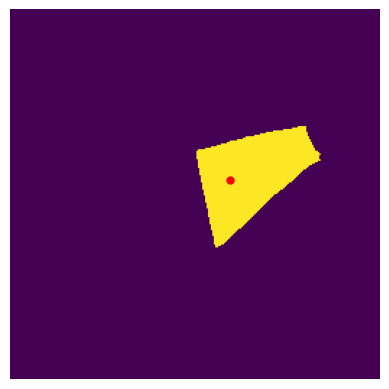

g165_00065_7
MAX IOU: 0.9260615110397339
Final MAX IOU: 0.9260615110397339


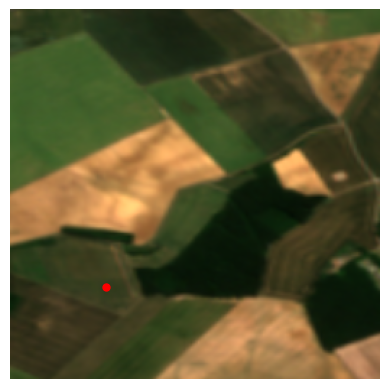

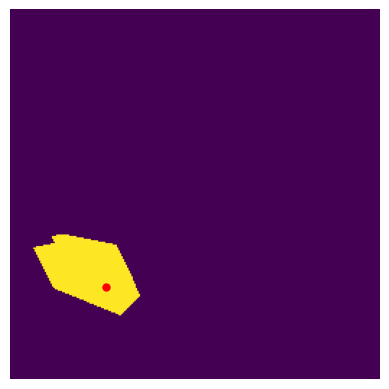

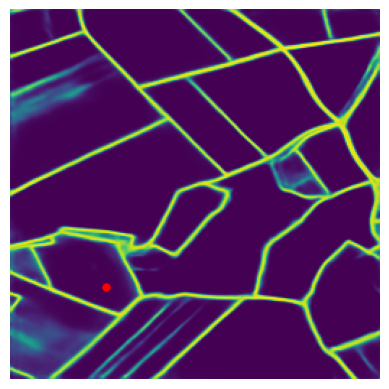

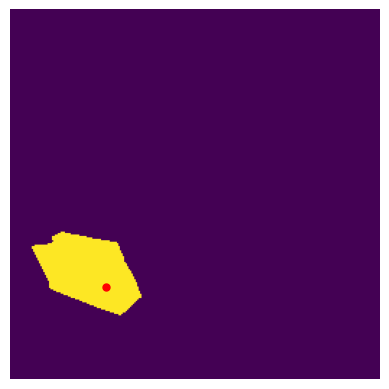

g165_00047_16
MAX IOU: 0.886956512928009
Final MAX IOU: 0.886956512928009


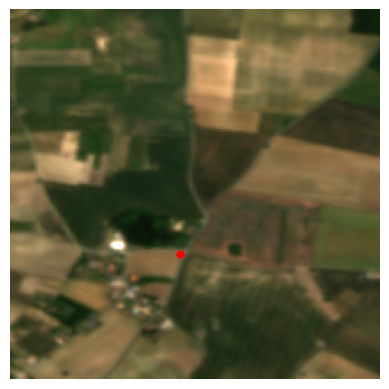

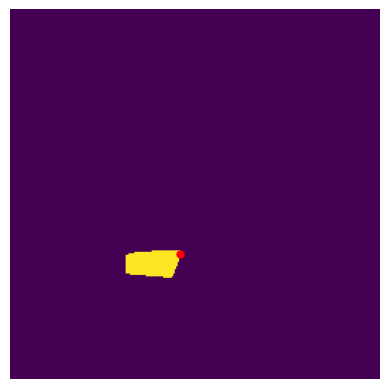

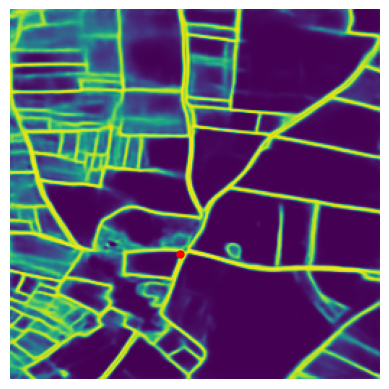

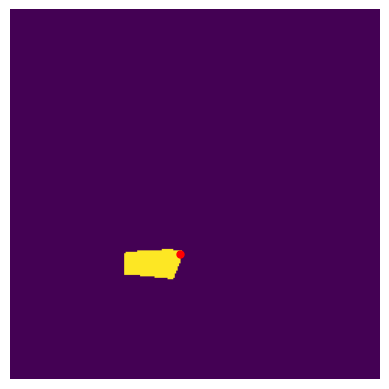

g165_00008_13
MAX IOU: 0.6934189200401306
Final MAX IOU: 0.6934189200401306


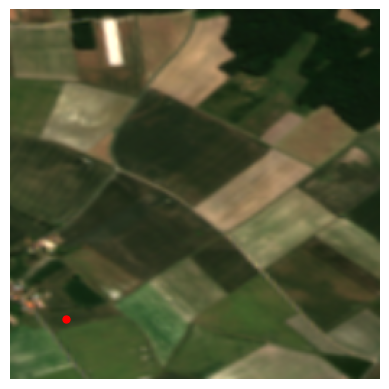

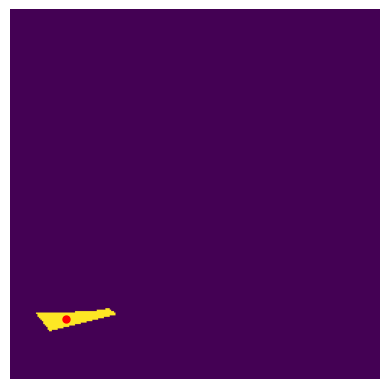

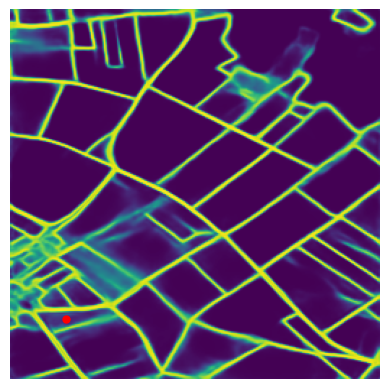

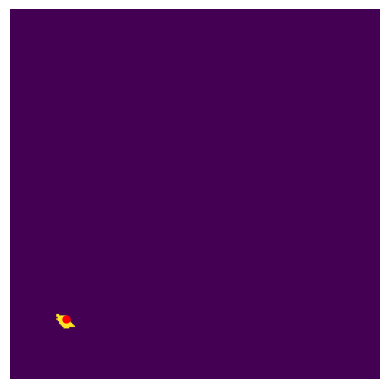

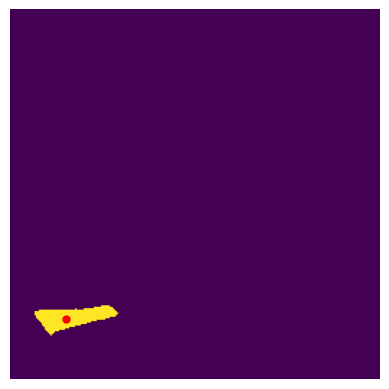

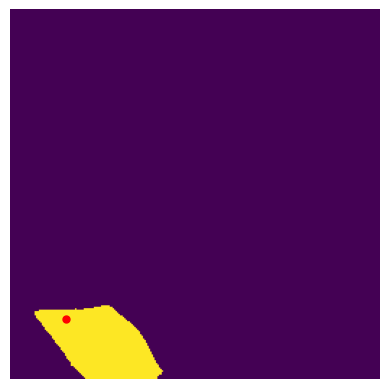

g165_00098_9
MAX IOU: 0.8005260825157166
Final MAX IOU: 0.8005260825157166


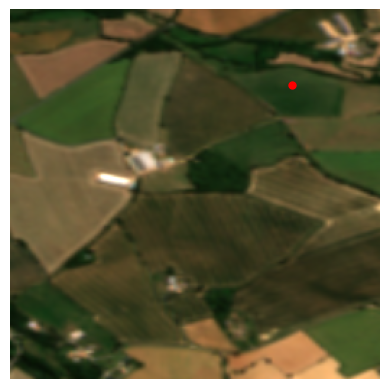

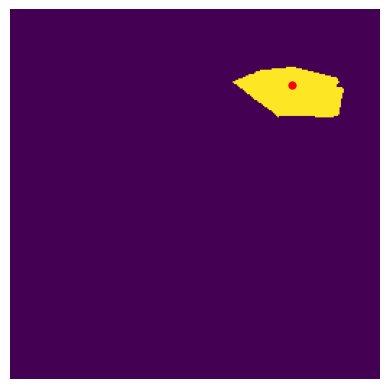

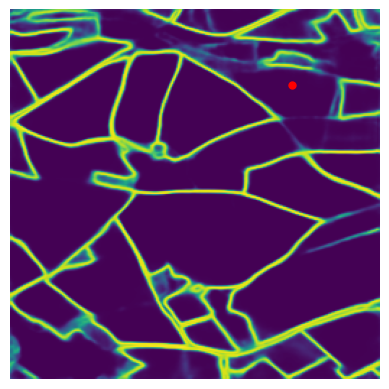

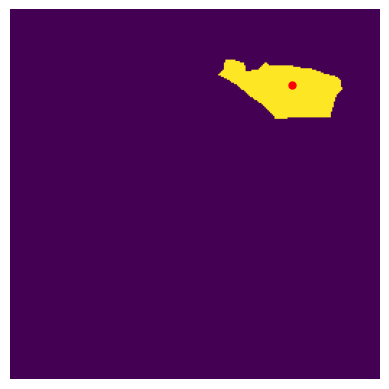

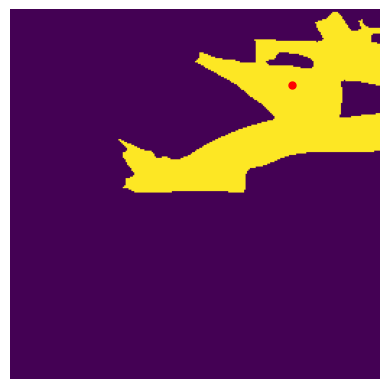

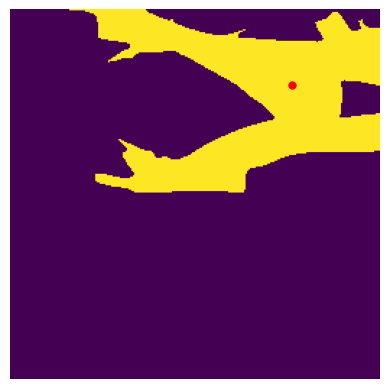

In [45]:
from skimage.color import label2rgb
np.random.seed(0)

for index, row in results_table_test.sample(n=5).iterrows():
    image_number = row["image_number"]
    coord = row["coord"]

    print(image_number)
    print("MAX IOU:", row["max IOU"])
    print("Final MAX IOU:", row["Final Mask max IOU"])
    rgb_img = rasterio.open(os.path.join('data/ftw_predictions/france_test/inputs_stacked', image_number+'.tif')).read()
    rgb_img = rgb_img[0:3].transpose(1, 2, 0)/ 3000
    plt.imshow(np.clip(rgb_img, 0, 1))
    plt.plot(coord[1], coord[0], "o", color="red", markersize=5)
    plt.axis('off')
    plt.show()


    #print("True Segmentation")
    true_segmentation = rasterio.open(os.path.join('data/ftw/france/label_masks/instance', image_number+'.tif')).read()[0]
    '''
    unique_labels = np.unique(true_segmentation)
    colors = [(np.random.rand(), np.random.rand(), np.random.rand()) for _ in unique_labels]
    true_segmentation_vis = label2rgb(true_segmentation, bg_label=0, bg_color=(0, 0, 0), colors=colors)
    plt.imshow(true_segmentation_vis)
    plt.plot(coord[1], coord[0], "o", color="white", markersize=5)
    plt.axis('off')
    plt.show()
    '''
    plt.imshow(true_segmentation==true_segmentation[coord[0].item(), coord[1].item()])
    plt.plot(coord[1], coord[0], "o", color="red", markersize=5)
    plt.axis('off')
    plt.show()
    
    #print("Predicted Boundary Probabilities")
    pred_probability = rasterio.open(os.path.join('data/ftw_predictions/france_test/predictions_3class/probability', image_number+'.tif')).read()[2]
    plt.imshow(pred_probability)
    plt.plot(coord[1], coord[0], "o", color="red", markersize=5)
    plt.axis('off')
    plt.show()
    
    '''
    #print("Confidence Set")
    for T in T_confidence_set:
        pred_segmentation = watershed(pred_probability, T)
        plt.imshow(pred_segmentation==pred_segmentation[coord[0].item(), coord[1].item()])
        plt.plot(coord[1], coord[0], "o", color="red", markersize=5)
        plt.axis('off')
        plt.show()
    '''

    #print("Confidence Set with Duplicates Removed")
    T_confidence_set_duplicates_removed = T_confidence_set[row["Final Mask Indices"]]
    for T in T_confidence_set_duplicates_removed:
        pred_segmentation = watershed(pred_probability, T)
        plt.imshow(pred_segmentation==pred_segmentation[coord[0].item(), coord[1].item()])
        plt.plot(coord[1], coord[0], "o", color="red", markersize=5)
        plt.axis('off')
        plt.show()

# Conformal calibration that includes removing duplicates

In [11]:
T_confidence_set = [0.001, 0.003, 0.12,  0.31,  0.58 ]

In [8]:
np.random.seed(0)

image_size = 256
points_per_image = 50
results = {"image_number": [], "coord": [], "IOUs": [], "Pred Mask Pair to IOUs": []}
for image_number in tqdm(image_numbers_calibration):
    xs = np.random.randint(image_size, size=points_per_image)
    ys = np.random.randint(image_size, size=points_per_image)
    true_segmentation = rasterio.open(os.path.join('data/ftw/france/label_masks/instance', image_number+'.tif')).read()[0]
    pred_probability = rasterio.open(os.path.join('data/ftw_predictions/france_test/predictions_3class/probability', image_number+'.tif')).read()[2]
    
    coords = []
    for x, y in zip(xs, ys):
        if true_segmentation[x, y] != 0:
            coord = (x, y)
            true_field = true_segmentation==true_segmentation[coord]
            true_field_indices = np.argwhere(true_field)
            # check if true field touches edge of image
            if (0 not in true_field_indices.flatten()) and (image_size-1 not in true_field_indices.flatten()):
                coords.append(coord)
    
    IOUs = []
    pred_shapes = []
    if len(coords) != 0:
        for T in T_confidence_set:
            pred_segmentation = watershed(pred_probability, T)
            IOUs_T = []
            pred_shapes_T = []
            for coord in coords:
                true_field = true_segmentation==true_segmentation[coord]
                pred_field = pred_segmentation==pred_segmentation[coord]
                IOU = iou(torch.from_numpy(true_field), torch.from_numpy(pred_field))
                pred_shapes_T.append(pred_field)
                IOUs_T.append(IOU)
            IOUs.append(IOUs_T)
            pred_shapes.append(pred_shapes_T)
        pair_to_iou_dicts = []
        for pred_shapes_coord in torch.from_numpy(np.swapaxes(pred_shapes, 0, 1)):
            pair_to_iou_dicts.append(compute_pair_to_iou_dict(pred_shapes_coord))
    
        # store results
        results["image_number"].extend(np.repeat(image_number, len(coords)))
        results["coord"].extend(coords)
        results["IOUs"].extend(np.array(IOUs).T.tolist())
        results["Pred Mask Pair to IOUs"].extend(pair_to_iou_dicts)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [01:17<00:00,  3.21it/s]


In [9]:
results_table_calibration = pd.DataFrame.from_dict(results)

In [9]:
IOU_threshold = 0.7

results_table_calibration["max IOU"] = results_table_calibration["IOUs"].map(lambda x: np.max(x))
results_table_calibration_high_IOUs = results_table_calibration[results_table_calibration["max IOU"] > IOU_threshold]

coverage = len(results_table_calibration_high_IOUs) / len(results_table_calibration)
print(coverage)

alpha = 0.2

0.8000807754442649


In [12]:
indices = np.arange(len(T_confidence_set))
IOU_threshold_duplicate_mask = 0.9
results_table_calibration["Final Mask Indices"] = results_table_calibration["Pred Mask Pair to IOUs"].apply(lambda x: remove_duplicate_masks(indices, x, iou_threshold=IOU_threshold_duplicate_mask))

results_table_calibration["Final Mask Number"] = results_table_calibration["Final Mask Indices"].apply(lambda x: len(x))
results_table_calibration["Final Mask IOUs"] = results_table_calibration.apply(lambda x: np.array(x["IOUs"])[x["Final Mask Indices"]], axis=1)
results_table_calibration["Final Mask max IOU"] = results_table_calibration["Final Mask IOUs"].map(lambda x: np.max(x))

results_table_calibration

image_number       coord  \
0      g212_00063_1  (211, 151)   
1      g212_00063_1   (165, 79)   
2      g212_00063_1   (142, 53)   
3      g165_00035_5   (177, 25)   
4      g165_00035_5   (174, 14)   
...             ...         ...   
2471  g212_00096_16  (174, 113)   
2472  g212_00096_16    (94, 60)   
2473  g212_00096_16  (186, 166)   
2474  g212_00096_16    (40, 82)   
2475  g212_00096_16    (98, 69)   

                                                   IOUs  \
0     [0.18637274205684662, 0.18637274205684662, 0.2...   
1     [0.8399508595466614, 0.8399508595466614, 0.885...   
2     [0.8399508595466614, 0.8399508595466614, 0.885...   
3     [0.23930130898952484, 0.33322814106941223, 0.3...   
4     [0.09575142711400986, 0.09575142711400986, 0.3...   
...                                                 ...   
2471  [0.9535355567932129, 0.9535355567932129, 0.698...   
2472  [0.5677839517593384, 0.5675342679023743, 0.567...   
2473  [0.9535355567932129, 0.9535355567932129, 0.698...   
2474  [0.5677839517593384, 0.5675342679023743, 0.567...   
2475  [0.5677839517593384, 0.5675342679023743, 0.567...   

                                 Pred Mask Pair to IOUs   max IOU  \
0     {(0, 1): 1.0, (0, 2): 0.70454544, (0, 3): 0.70...  0.256972   
1     {(0, 1): 1.0, (0, 2): 0.9469136, (0, 3): 0.946...  0.885039   
2     {(0, 1): 1.0, (0, 2): 0.9469136, (0, 3): 0.946...  0.885039   
3     {(0, 1): 0.47660378, (0, 2): 0.2526, (0, 3): 0...  0.333228   
4     {(0, 1): 1.0, (0, 2): 0.0306, (0, 3): 0.029599...  0.304822   
...                                                 ...       ...   
2471  {(0, 1): 1.0, (0, 2): 0.73226357, (0, 3): 0.73...  0.953536   
2472  {(0, 1): 0.9995603, (0, 2): 0.9995603, (0, 3):...  0.567784   
2473  {(0, 1): 1.0, (0, 2): 0.73226357, (0, 3): 0.73...  0.953536   
2474  {(0, 1): 0.9995603, (0, 2): 0.9995603, (0, 3):...  0.567784   
2475  {(0, 1): 0.9995603, (0, 2): 0.9995603, (0, 3):...  0.567784   

     Final Mask Indices  Final Mask Number  \
0                [0, 2]                  2   
1                [0, 4]                  2   
2                [0, 4]                  2   
3             [0, 1, 2]                  3   
4                [0, 2]                  2   
...                 ...                ...   
2471          [0, 2, 4]                  3   
2472             [0, 4]                  2   
2473          [0, 2, 4]                  3   
2474             [0, 4]                  2   
2475             [0, 4]                  2   

                                        Final Mask IOUs  Final Mask max IOU  
0             [0.18637274205684662, 0.2569721043109894]            0.256972  
1               [0.8399508595466614, 0.724574863910675]            0.839951  
2               [0.8399508595466614, 0.724574863910675]            0.839951  
3     [0.23930130898952484, 0.33322814106941223, 0.3...            0.333228  
4             [0.09575142711400986, 0.3048223853111267]            0.304822  
...                                                 ...                 ...  
2471  [0.9535355567932129, 0.6982393860816956, 0.378...            0.953536  
2472          [0.5677839517593384, 0.25989609956741333]            0.567784  
2473  [0.9535355567932129, 0.6982393860816956, 0.378...            0.953536  
2474          [0.5677839517593384, 0.25989609956741333]            0.567784  
2475          [0.5677839517593384, 0.25989609956741333]            0.567784  

[2476 rows x 9 columns]

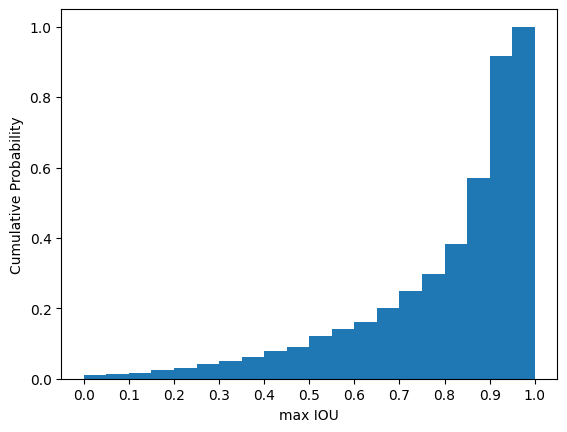

In [13]:
plt.hist(results_table_calibration["max IOU"], bins=np.arange(0, 1.01, .05), density=True, cumulative=True)
plt.xlabel("max IOU")
plt.ylabel("Cumulative Probability")
plt.xticks(np.arange(0, 1.01, 0.1))
plt.show()

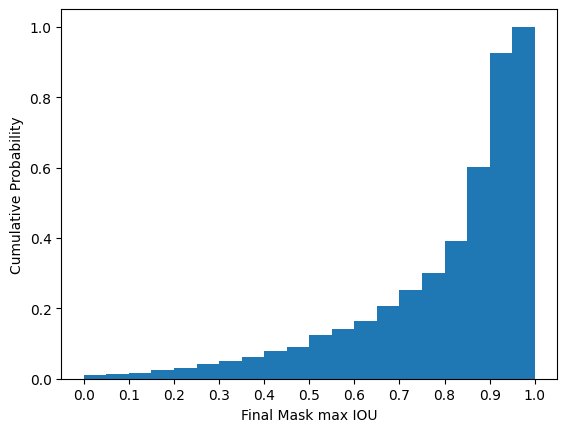

In [14]:
plt.hist(results_table_calibration["Final Mask max IOU"], bins=np.arange(0, 1.01, .05), density=True, cumulative=True)
plt.xlabel("Final Mask max IOU")
plt.ylabel("Cumulative Probability")
plt.xticks(np.arange(0, 1.01, 0.1))
plt.show()

In [15]:
q = np.quantile(results_table_calibration["Final Mask max IOU"], alpha)
print(q)

0.6960647702217102


In [16]:
file = open('data/ftw_predictions/france_test/conformal_ious_calibration_with_pairwise_IOUs_more_T_values_improved_remove_duplicate_masks.pkl', 'wb')
pickle.dump(results_table_calibration, file)
file.close()

In [17]:
# check coverage on test set
file = open('data/ftw_predictions/france_test/conformal_ious_test_with_pairwise_IOUs_more_T_values.pkl', 'rb')
results_table_test = pickle.load(file)
file.close()

In [18]:
indices = np.arange(len(T_confidence_set))
IOU_threshold_duplicate_mask = 0.9
results_table_test["Final Mask Indices"] = results_table_test["Pred Mask Pair to IOUs"].apply(lambda x: remove_duplicate_masks(indices, x, iou_threshold=IOU_threshold_duplicate_mask))

results_table_test["Final Mask Number"] = results_table_test["Final Mask Indices"].apply(lambda x: len(x))
results_table_test["Final Mask IOUs"] = results_table_test.apply(lambda x: np.array(x["IOUs"])[x["Final Mask Indices"]], axis=1)
results_table_test["Final Mask max IOU"] = results_table_test["Final Mask IOUs"].map(lambda x: np.max(x))

# Compute coverage after removing duplicate masks
results_table_test_high_IOUs = results_table_test[results_table_test["Final Mask max IOU"] > q]
coverage = len(results_table_test_high_IOUs) / len(results_table_test)
print(coverage)

0.797164667393675


# Compare test coverage using baseline model (binarize field boundary probability map, then use watershed with T=0)

In [21]:
q = 0.6960647702217102
best_T_calibration = 0.24

In [22]:
np.random.seed(0)

image_size = 256
points_per_image = 50
results = {"image_number": [], "coord": [], "IOUs": []}
for image_number in tqdm(image_numbers_test):
    xs = np.random.randint(image_size, size=points_per_image)
    ys = np.random.randint(image_size, size=points_per_image)
    true_segmentation = rasterio.open(os.path.join('data/ftw/france/label_masks/instance', image_number+'.tif')).read()[0]
    pred_probability = rasterio.open(os.path.join('data/ftw_predictions/france_test/predictions_3class/probability', image_number+'.tif')).read()[2]
    
    coords = []
    for x, y in zip(xs, ys):
        if true_segmentation[x, y] != 0:
            coord = (x, y)
            true_field = true_segmentation==true_segmentation[coord]
            true_field_indices = np.argwhere(true_field)
            # check if true field touches edge of image
            if (0 not in true_field_indices.flatten()) and (image_size-1 not in true_field_indices.flatten()):
                coords.append(coord)
    
    IOUs = []
    if len(coords) != 0:
        for T in [best_T_calibration]:
            pred_segmentation = watershed(pred_probability, T)
            IOUs_T = []
            for coord in coords:
                true_field = true_segmentation==true_segmentation[coord]
                pred_field = pred_segmentation==pred_segmentation[coord]
                IOU = iou(torch.from_numpy(true_field), torch.from_numpy(pred_field)).numpy().item()
                IOUs_T.append(IOU)
            IOUs.append(IOUs_T)
        
    
    # store results
    results["image_number"].extend(np.repeat(image_number, len(coords)))
    results["coord"].extend(coords)
    results["IOUs"].extend(np.array(IOUs).T.tolist())

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 12.99it/s]


In [23]:
results_table_baseline = pd.DataFrame.from_dict(results)

In [24]:
file = open('data/ftw_predictions/france_test/conformal_ious_test_baseline.pkl', 'wb')
pickle.dump(results_table_baseline, file)
file.close()

In [25]:
results_table_baseline["IOU"] = results_table_baseline["IOUs"].apply(lambda x: x[0])
results_table_baseline

image_number       coord                  IOUs       IOU
0    g165_00003_0   (67, 127)  [0.8354430198669434]  0.835443
1    g165_00003_0  (103, 202)  [0.7164685726165771]  0.716469
2    g165_00003_0   (21, 163)  [0.7522796392440796]  0.752280
3    g165_00003_0   (87, 114)  [0.8513011336326599]  0.851301
4    g165_00003_0   (70, 183)  [0.2523574233055115]  0.252357
..            ...         ...                   ...       ...
912  g212_00037_6  (161, 131)  [0.8583420515060425]  0.858342
913  g212_00037_6   (117, 86)  [0.9332780838012695]  0.933278
914  g212_00037_6  (106, 129)  [0.5370800495147705]  0.537080
915  g212_00037_6  (200, 155)  [0.9462076425552368]  0.946208
916  g212_00037_6  (105, 128)  [0.5370800495147705]  0.537080

[917 rows x 4 columns]

In [26]:
results_table_baseline_high_IOUs = results_table_baseline[results_table_baseline["IOU"] > q]
coverage = len(results_table_baseline_high_IOUs) / len(results_table_baseline)
print(coverage)

0.6630316248636859


# Figures for paper

In [7]:
T_confidence_set = np.array([0.001, 0.003, 0.12,  0.31,  0.58 ])

In [8]:
q = 0.6960647702217102
tau = 0.7
alpha = 0.2

In [9]:
file = open('data/ftw_predictions/france_test/conformal_ious_test_with_pairwise_IOUs_more_T_values.pkl', 'rb')
results_table_test = pickle.load(file)
file.close()

indices = np.arange(len(T_confidence_set))
IOU_threshold_duplicate_mask = 0.9
results_table_test["Final Mask Indices"] = results_table_test["Pred Mask Pair to IOUs"].apply(lambda x: remove_duplicate_masks(indices, x, iou_threshold=IOU_threshold_duplicate_mask))

results_table_test["Final Mask Number"] = results_table_test["Final Mask Indices"].apply(lambda x: len(x))
results_table_test["Final Mask IOUs"] = results_table_test.apply(lambda x: np.array(x["IOUs"])[x["Final Mask Indices"]], axis=1)
results_table_test["Final Mask max IOU"] = results_table_test["Final Mask IOUs"].map(lambda x: np.max(x))

In [10]:
np.random.seed(0)

baseline_segmentations = []
confidence_sets = []
for index, row in results_table_test.sample(n=5).sort_values(by='Final Mask Number', ascending=True).iterrows():
    image_number = row["image_number"]
    T_confidence_set_duplicates_removed = T_confidence_set[row["Final Mask Indices"]]
    
    pred_probability = rasterio.open(os.path.join('data/ftw_predictions/france_test/predictions_3class/probability', image_number+'.tif')).read()[2]
    
    #print("Baseline Model Prediction")
    baseline_segmentation = watershed(pred_probability, 0.24)
    
    #print("Confidence Set with Duplicates Removed")
    confidence_set = []
    for j, T in enumerate(T_confidence_set_duplicates_removed):
        pred_segmentation = watershed(pred_probability, T)
        confidence_set.append(pred_segmentation)

    baseline_segmentations.append(baseline_segmentation)
    confidence_sets.append(confidence_set)

g165_00065_7
MAX IOU: 0.9260615110397339
Final MAX IOU: 0.9260615110397339
g165_00047_16
MAX IOU: 0.886956512928009
Final MAX IOU: 0.886956512928009
g212_00054_15
MAX IOU: 0.9471971988677979
Final MAX IOU: 0.9296835660934448
g165_00008_13
MAX IOU: 0.6934189200401306
Final MAX IOU: 0.6934189200401306
g165_00098_9
MAX IOU: 0.8005260825157166
Final MAX IOU: 0.8005260825157166


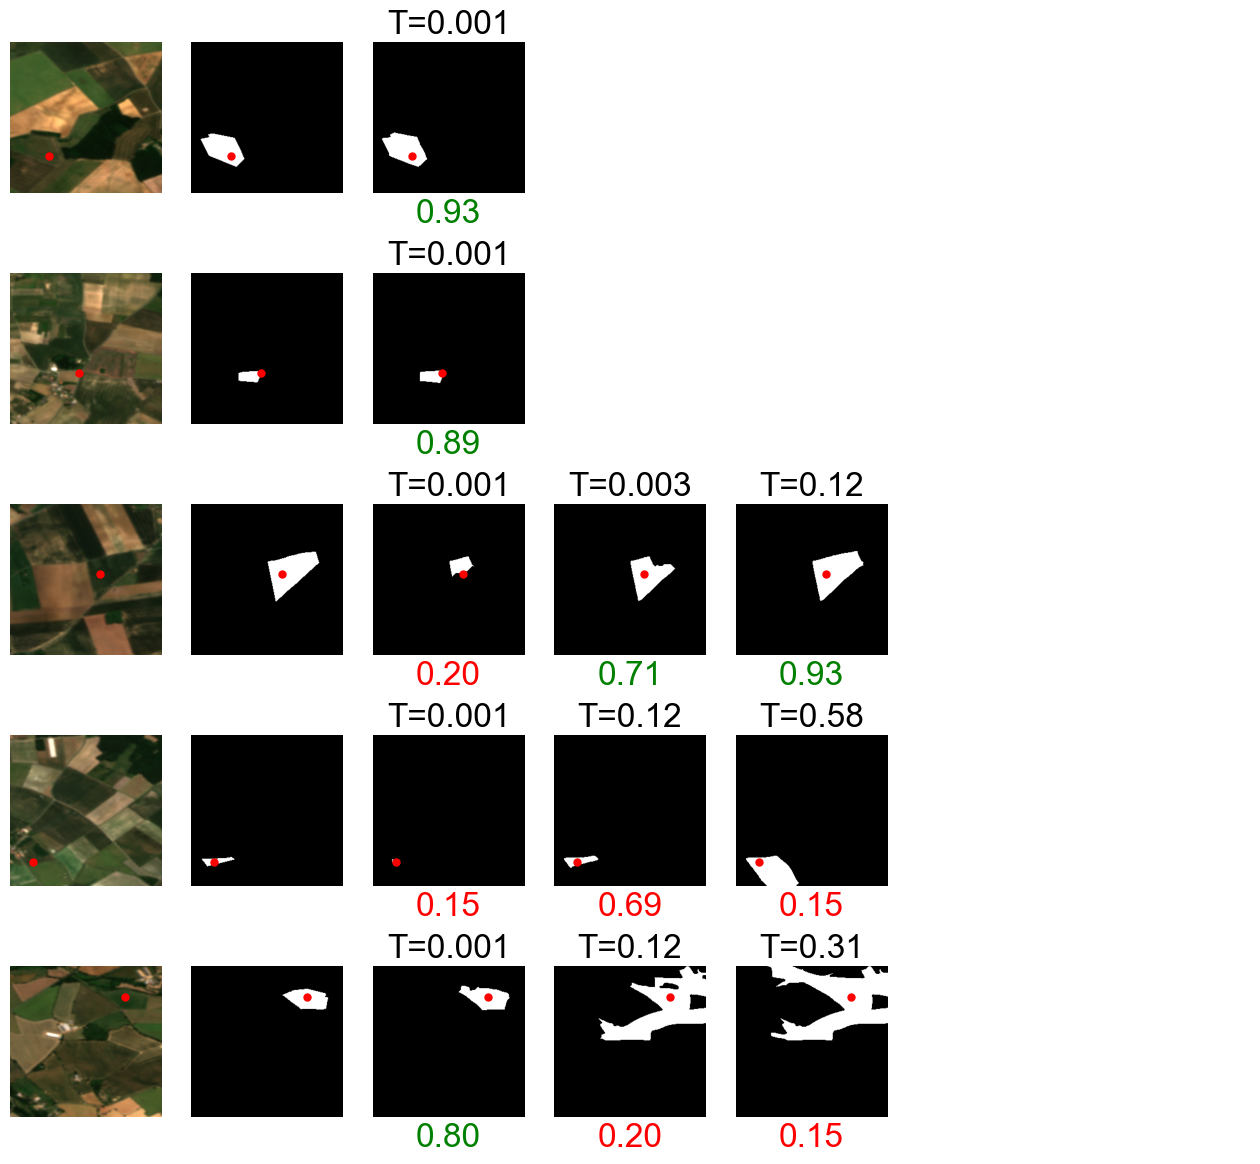

In [13]:
plt.rcParams["font.sans-serif"] = "Arial"
plt.rc('font', size=24) 
plt.rc('axes', titlesize=24)     
plt.rc('axes', labelsize=24)
plt.rc('figure', titlesize=24)

from skimage.color import label2rgb
np.random.seed(0)

fig, axs = plt.subplots(nrows=5, ncols=7, figsize=(16, 14.5))

i=0
for index, row in results_table_test.sample(n=5).sort_values(by='Final Mask Number', ascending=True).iterrows():
    image_number = row["image_number"]
    coord = row["coord"]
    T_confidence_set_duplicates_removed = T_confidence_set[row["Final Mask Indices"]]

    print(image_number)
    print("MAX IOU:", row["max IOU"])
    print("Final MAX IOU:", row["Final Mask max IOU"])

    rgb_img = rasterio.open(os.path.join('data/ftw_predictions/france_test/inputs_stacked', image_number+'.tif')).read()
    rgb_img = rgb_img[0:3].transpose(1, 2, 0)/ 3000
    plt.sca(axs[i, 0])
    plt.imshow(np.clip(rgb_img, 0, 1))
    plt.plot(coord[1], coord[0], "o", color="red", markersize=5)
    plt.axis('off')

    #print("True Segmentation")
    true_segmentation = rasterio.open(os.path.join('data/ftw/france/label_masks/instance', image_number+'.tif')).read()[0]
    plt.sca(axs[i, 1])
    plt.imshow(true_segmentation==true_segmentation[coord[0].item(), coord[1].item()], cmap='gray')
    plt.plot(coord[1], coord[0], "o", color="red", markersize=5)
    plt.axis('off')

    pred_probability = rasterio.open(os.path.join('data/ftw_predictions/france_test/predictions_3class/probability', image_number+'.tif')).read()[2]
    
    '''
    #print("Predicted Boundary Probabilities")
    plt.imshow(pred_probability)
    plt.plot(coord[1], coord[0], "o", color="red", markersize=5)
    plt.axis('off')
    plt.show()
    '''
    
    '''
    #print("Baseline Model Prediction")
    plt.sca(axs[i, 2])
    baseline_segmentation = baseline_segmentations[i]
    plt.imshow(baseline_segmentation==baseline_segmentation[coord[0].item(), coord[1].item()], cmap='gray')
    plt.plot(coord[1], coord[0], "o", color="red", markersize=5)
    plt.axis('off')
    '''
    
    '''
    #print("Confidence Set")
    for T in T_confidence_set:
        pred_segmentation = watershed(pred_probability, T)
        plt.imshow(pred_segmentation==pred_segmentation[coord[0].item(), coord[1].item()])
        plt.plot(coord[1], coord[0], "o", color="red", markersize=5)
        plt.axis('off')
        plt.show()
    '''

    #print("Confidence Set with Duplicates Removed")
    true_field = true_segmentation==true_segmentation[coord]
    for j, pred_segmentation in enumerate(confidence_sets[i]):
        pred_field = pred_segmentation==pred_segmentation[coord]
        IOU = iou(torch.from_numpy(true_field), torch.from_numpy(pred_field)).numpy().item()
        
        plt.sca(axs[i, 2+j])
        plt.imshow(pred_segmentation==pred_segmentation[coord[0].item(), coord[1].item()], cmap='gray')
        plt.plot(coord[1], coord[0], "o", color="red", markersize=5)
        
        ax = plt.gca()
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
        if T_confidence_set_duplicates_removed[j] < 0.01:
            plt.title(f"T={T_confidence_set_duplicates_removed[j]:.3f}")
        else:
            plt.title(f"T={T_confidence_set_duplicates_removed[j]:.2f}")

        if IOU > tau:
            plt.xlabel(f"{np.round(IOU, 2):.2f}", color='green')
        else:
            plt.xlabel(f"{np.round(IOU, 2):.2f}", color='red')

    # remove empty grids
    for j in range(2+len(T_confidence_set_duplicates_removed), 7):
        axs[i, j].axis('off')

    i+= 1
    
#plt.tight_layout()
plt.savefig('plots/field-delineation-examples.png', dpi=300, bbox_inches='tight')
plt.show()

g165_00099_11
MAX IOU: 0.9333895444869995
Final MAX IOU: 0.9333895444869995


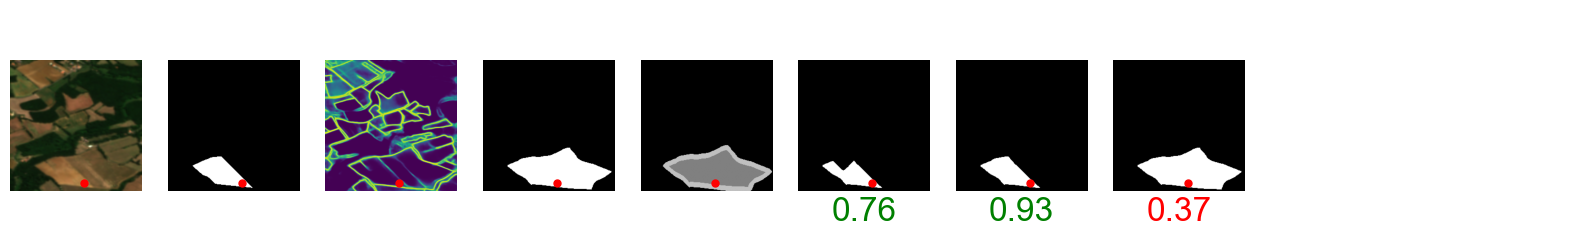

In [40]:
from scipy import ndimage
from skimage.color import label2rgb

plt.rcParams["font.sans-serif"] = "Arial"
plt.rc('font', size=24) 
plt.rc('axes', titlesize=24)     
plt.rc('axes', labelsize=24)
plt.rc('figure', titlesize=24)

np.random.seed(13)

fig, axs = plt.subplots(nrows=1, ncols=10, figsize=(20, 3))

i=0
for index, row in results_table_test.sample(n=1).iterrows():
    image_number = row["image_number"]
    coord = row["coord"]
    T_confidence_set_duplicates_removed = T_confidence_set[row["Final Mask Indices"]]

    print(image_number)
    print("MAX IOU:", row["max IOU"])
    print("Final MAX IOU:", row["Final Mask max IOU"])

    rgb_img = rasterio.open(os.path.join('data/ftw_predictions/france_test/inputs_stacked', image_number+'.tif')).read()
    rgb_img = rgb_img[0:3].transpose(1, 2, 0)/ 3000
    plt.sca(axs[0])
    plt.imshow(np.clip(rgb_img, 0, 1))
    plt.plot(coord[1], coord[0], "o", color="red", markersize=5)
    plt.axis('off')

    #print("True Segmentation")
    true_segmentation = rasterio.open(os.path.join('data/ftw/france/label_masks/instance', image_number+'.tif')).read()[0]
    plt.sca(axs[1])
    plt.imshow(true_segmentation==true_segmentation[coord[0].item(), coord[1].item()], cmap='gray')
    plt.plot(coord[1], coord[0], "o", color="red", markersize=5)
    plt.axis('off')

    true_field = true_segmentation==true_segmentation[coord]
    pred_probability = rasterio.open(os.path.join('data/ftw_predictions/france_test/predictions_3class/probability', image_number+'.tif')).read()[2]
    
    #print("Predicted Boundary Probabilities")
    plt.sca(axs[2])
    plt.imshow(pred_probability)
    plt.plot(coord[1], coord[0], "o", color="red", markersize=5)
    plt.axis('off')
    
    #print("Baseline Model Prediction")
    plt.sca(axs[3])
    baseline_segmentation = watershed(pred_probability, 0.24)
    baseline_segmentation = baseline_segmentation==baseline_segmentation[coord[0].item(), coord[1].item()]
    plt.imshow(baseline_segmentation, cmap='gray')
    plt.plot(coord[1], coord[0], "o", color="red", markersize=5)
    plt.axis('off')

    #print("Dilation")
    plt.sca(axs[4])
    dilation = ndimage.binary_dilation(baseline_segmentation, iterations=5).astype(int)
    erosion = ndimage.binary_erosion(baseline_segmentation, iterations=5).astype(int)
    plt.imshow(0.75*(dilation-erosion)+0.5*erosion, cmap='gray', vmin=0, vmax=1)
    plt.plot(coord[1], coord[0], "o", color="red", markersize=5)
    plt.axis('off')

    #print("Confidence Set with Duplicates Removed")
    for j, T in enumerate(T_confidence_set_duplicates_removed):
        pred_segmentation = watershed(pred_probability, T)
        pred_field = pred_segmentation==pred_segmentation[coord]
        IOU = iou(torch.from_numpy(true_field), torch.from_numpy(pred_field)).numpy().item()
        
        plt.sca(axs[5+j])
        plt.imshow(pred_segmentation==pred_segmentation[coord[0].item(), coord[1].item()], cmap='gray')
        plt.plot(coord[1], coord[0], "o", color="red", markersize=5)
        
        ax = plt.gca()
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
        #plt.title(f"T={T_confidence_set_duplicates_removed[j]:.2f}")

        if IOU > tau:
            plt.xlabel(f"{np.round(IOU, 2):.2f}", color='green')
        else:
            plt.xlabel(f"{np.round(IOU, 2):.2f}", color='red')

    # remove empty grids
    for j in range(5+len(T_confidence_set_duplicates_removed), 10):
        axs[j].axis('off')

    i+= 1
    
#plt.tight_layout()
plt.savefig('plots/field-delineation-single-example-undersegment.png', dpi=300, bbox_inches='tight')
plt.show()

g165_00003_0
MAX IOU: 0.9391230344772339
Final MAX IOU: 0.9391230344772339


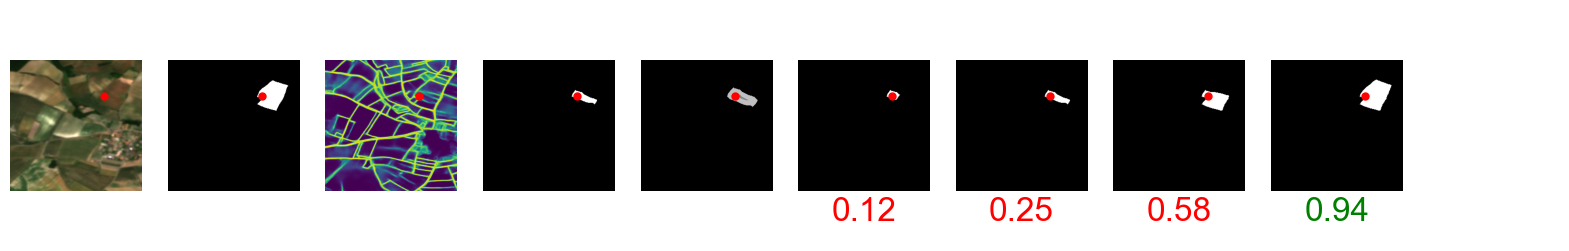

In [54]:
from scipy import ndimage
from skimage.color import label2rgb

plt.rcParams["font.sans-serif"] = "Arial"
plt.rc('font', size=24) 
plt.rc('axes', titlesize=24)     
plt.rc('axes', labelsize=24)
plt.rc('figure', titlesize=24)

np.random.seed(26)

fig, axs = plt.subplots(nrows=1, ncols=10, figsize=(20, 3))

i=0
for index, row in results_table_test.sample(n=1).iterrows():
    image_number = row["image_number"]
    coord = row["coord"]
    T_confidence_set_duplicates_removed = T_confidence_set[row["Final Mask Indices"]]

    print(image_number)
    print("MAX IOU:", row["max IOU"])
    print("Final MAX IOU:", row["Final Mask max IOU"])

    rgb_img = rasterio.open(os.path.join('data/ftw_predictions/france_test/inputs_stacked', image_number+'.tif')).read()
    rgb_img = rgb_img[0:3].transpose(1, 2, 0)/ 3000
    plt.sca(axs[0])
    plt.imshow(np.clip(rgb_img, 0, 1))
    plt.plot(coord[1], coord[0], "o", color="red", markersize=5)
    plt.axis('off')

    #print("True Segmentation")
    true_segmentation = rasterio.open(os.path.join('data/ftw/france/label_masks/instance', image_number+'.tif')).read()[0]
    plt.sca(axs[1])
    plt.imshow(true_segmentation==true_segmentation[coord[0].item(), coord[1].item()], cmap='gray')
    plt.plot(coord[1], coord[0], "o", color="red", markersize=5)
    plt.axis('off')

    true_field = true_segmentation==true_segmentation[coord]
    pred_probability = rasterio.open(os.path.join('data/ftw_predictions/france_test/predictions_3class/probability', image_number+'.tif')).read()[2]
    
    #print("Predicted Boundary Probabilities")
    plt.sca(axs[2])
    plt.imshow(pred_probability)
    plt.plot(coord[1], coord[0], "o", color="red", markersize=5)
    plt.axis('off')
    
    #print("Baseline Model Prediction")
    plt.sca(axs[3])
    baseline_segmentation = watershed(pred_probability, 0.24)
    baseline_segmentation = baseline_segmentation==baseline_segmentation[coord[0].item(), coord[1].item()]
    plt.imshow(baseline_segmentation, cmap='gray')
    plt.plot(coord[1], coord[0], "o", color="red", markersize=5)
    plt.axis('off')

    #print("Dilation")
    plt.sca(axs[4])
    dilation = ndimage.binary_dilation(baseline_segmentation, iterations=5).astype(int)
    erosion = ndimage.binary_erosion(baseline_segmentation, iterations=5).astype(int)
    plt.imshow(0.75*(dilation-erosion)+0.5*erosion, cmap='gray', vmin=0, vmax=1)
    plt.plot(coord[1], coord[0], "o", color="red", markersize=5)
    plt.axis('off')

    #print("Confidence Set with Duplicates Removed")
    for j, T in enumerate(T_confidence_set_duplicates_removed):
        pred_segmentation = watershed(pred_probability, T)
        pred_field = pred_segmentation==pred_segmentation[coord]
        IOU = iou(torch.from_numpy(true_field), torch.from_numpy(pred_field)).numpy().item()
        
        plt.sca(axs[5+j])
        plt.imshow(pred_segmentation==pred_segmentation[coord[0].item(), coord[1].item()], cmap='gray')
        plt.plot(coord[1], coord[0], "o", color="red", markersize=5)
        
        ax = plt.gca()
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
        #plt.title(f"T={T_confidence_set_duplicates_removed[j]:.2f}")

        if IOU > tau:
            plt.xlabel(f"{np.round(IOU, 2):.2f}", color='green')
        else:
            plt.xlabel(f"{np.round(IOU, 2):.2f}", color='red')

    # remove empty grids
    for j in range(5+len(T_confidence_set_duplicates_removed), 10):
        axs[j].axis('off')

    i+= 1
    5
#plt.tight_layout()
plt.savefig('plots/field-delineation-single-example-oversegment.png', dpi=300, bbox_inches='tight')
plt.show()

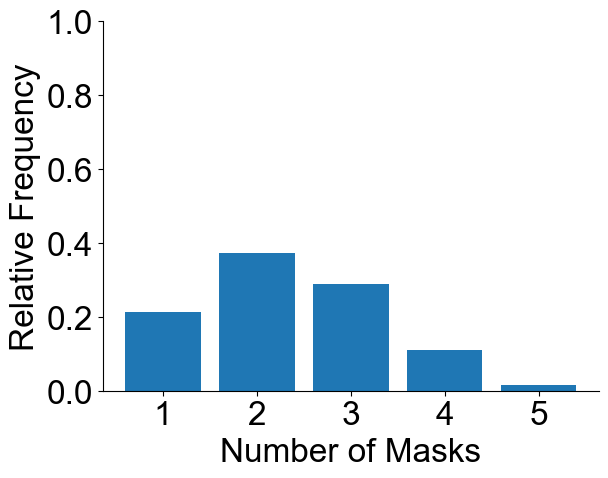

In [21]:
plt.rcParams["font.sans-serif"] = "Arial"

plt.rc('font', size=24)          
plt.rc('axes', titlesize=24)     
plt.rc('axes', labelsize=24)    
plt.rc('xtick', labelsize=24)    
plt.rc('ytick', labelsize=24)    
plt.rc('figure', titlesize=24)

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.bar(results_table_test['Final Mask Number'].value_counts().index, results_table_test['Final Mask Number'].value_counts().values/len(results_table_test))
plt.xticks(np.arange(1, 6))
plt.ylim([0, 1])
plt.xlabel("Number of Masks")
plt.ylabel("Relative Frequency")
plt.show()

g212_00054_15


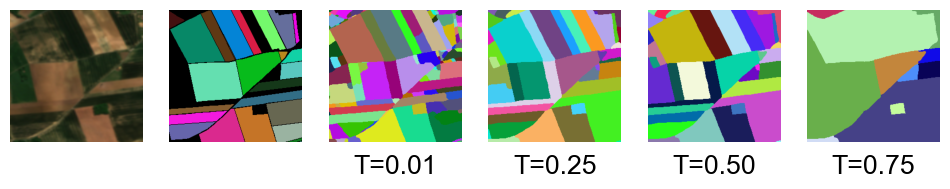

In [63]:
plt.rcParams["font.sans-serif"] = "Arial"
plt.rc('font', size=16) 

from skimage.color import label2rgb
np.random.seed(0)

fig, axs = plt.subplots(nrows=1, ncols=6,  figsize=(12, 5))

for index, row in results_table_test.sample(n=1).iterrows():
    image_number = row["image_number"]
    coord = row["coord"]
    T_confidence_set_duplicates_removed = T_confidence_set[row["Final Mask Indices"]]

    print(image_number)

    rgb_img = rasterio.open(os.path.join('data/ftw_predictions/france_test/inputs_stacked', image_number+'.tif')).read()
    rgb_img = rgb_img[0:3].transpose(1, 2, 0)/ 3000
    plt.sca(axs[0])
    plt.imshow(np.clip(rgb_img, 0, 1))
    plt.axis('off')

    true_segmentation = rasterio.open(os.path.join('data/ftw/france/label_masks/instance', image_number+'.tif')).read()[0]
    unique_labels = np.unique(true_segmentation)
    colors = [(np.random.rand(), np.random.rand(), np.random.rand()) for _ in unique_labels]
    true_segmentation = label2rgb(true_segmentation, bg_label=0, bg_color=(0, 0, 0), colors=colors)
    plt.sca(axs[1])
    plt.imshow(true_segmentation)
    plt.axis('off')

    pred_probability = rasterio.open(os.path.join('data/ftw_predictions/france_test/predictions_3class/probability', image_number+'.tif')).read()[2]
    '''
    plt.sca(axs[1])
    plt.imshow(pred_probability)
    plt.axis('off')
    '''
    
    for j, T in enumerate([.01, .25, .5, .75]):
        pred_segmentation = watershed(pred_probability, T)
        unique_labels = np.unique(pred_segmentation)
        colors = [(np.random.rand(), np.random.rand(), np.random.rand()) for _ in unique_labels]
        pred_segmentation = label2rgb(pred_segmentation, colors=colors)
        
        plt.sca(axs[2+j])
        plt.imshow(pred_segmentation)
        plt.axis('off')
        plt.title(f"T={T:.2f}", y=-0.3)

plt.show()
    

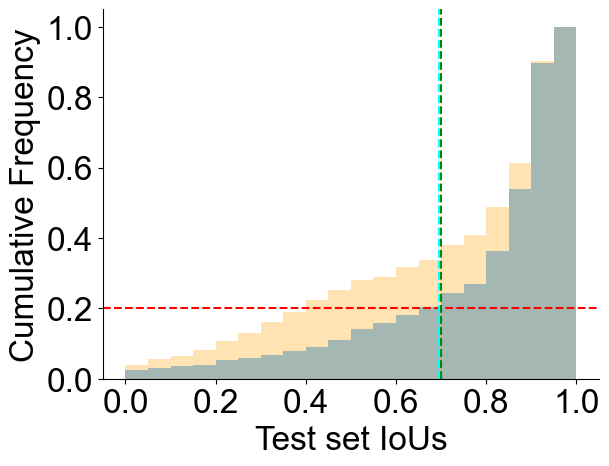

In [29]:
plt.rcParams["font.sans-serif"] = "Arial"
plt.rc('font', size=24)          
plt.rc('axes', titlesize=24)     
plt.rc('axes', labelsize=24)    
plt.rc('xtick', labelsize=24)    
plt.rc('ytick', labelsize=24)    
plt.rc('figure', titlesize=24)

file = open('data/ftw_predictions/france_test/conformal_ious_test_baseline.pkl', 'rb')
results_table_baseline = pickle.load(file)
file.close()

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.hist(results_table_baseline["IOUs"].apply(lambda x: x[0]), bins=np.arange(0, 1.01, .05), density=True, cumulative=True, alpha=0.3, label='baseline', color='orange')
plt.hist(results_table_test["Final Mask max IOU"], bins=np.arange(0, 1.01, .05), density=True, cumulative=True, alpha=0.4, label='conformal')
plt.xlabel("Test set IoUs")
plt.ylabel("Cumulative Frequency")
plt.xticks(np.arange(0, 1.01, 0.2))
plt.yticks(np.arange(0, 1.01, 0.2))
plt.axhline(alpha, color='red', linestyle='dashed', label=r'$\alpha$')
plt.axvline(tau, color='green', linestyle='dashed', label=r'$\tau$')
plt.axvline(q, color='cyan', linestyle='dashed', label=r'$\theta$')
#plt.legend(bbox_to_anchor=(1.05, 1))

plt.show()

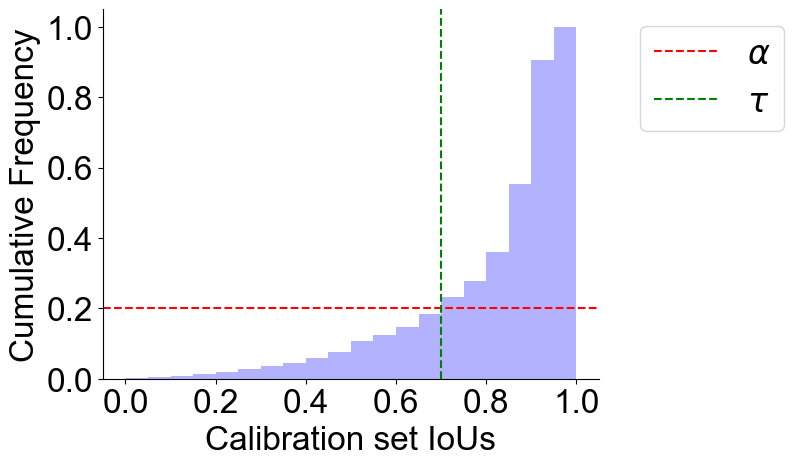

In [19]:
plt.rcParams["font.sans-serif"] = "Arial"
plt.rc('font', size=24)          
plt.rc('axes', titlesize=24)     
plt.rc('axes', labelsize=24)    
plt.rc('xtick', labelsize=24)    
plt.rc('ytick', labelsize=24)    
plt.rc('figure', titlesize=24)

file = open('data/ftw_predictions/france_test/conformal_ious_more_T_values.pkl', 'rb')
results_table_calibration = pickle.load(file)
file.close()

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.hist(results_table_calibration["IOUs"].map(lambda x: np.max(x)), bins=np.arange(0, 1.01, .05), density=True, cumulative=True, alpha=0.3, color='blue')
plt.xlabel("Calibration set IoUs")
plt.ylabel("Cumulative Frequency")
plt.xticks(np.arange(0, 1.01, 0.2))
plt.yticks(np.arange(0, 1.01, 0.2))
plt.axhline(alpha, color='red', linestyle='dashed', label=r'$\alpha$')
plt.axvline(tau, color='green', linestyle='dashed', label=r'$\tau$')
plt.legend(bbox_to_anchor=(1.05, 1))

plt.show()